In [1]:
import os

#add the root directory
os.chdir('../')

# A posteriori simulations using tabulation

In [2]:
import numpy as np
import pandas as pd
from ANN_regression import *
import pickle
from datetime import datetime
from loader import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
import h5py
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from matplotlib.patches import Rectangle
import matplotlib.cm as cm

### Load the data

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]

PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)
PV_Xu_source_train = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_source_train = PV_Xu_source_train.to_numpy().reshape(-1,1)

In [5]:
# Rescale every trajectory from 0 to 1 (each having its own mixture fraction)

df = pd.DataFrame({
    'PV Xu': PV_Xu_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_Xu_scaled'] = df.groupby('mixture_fraction')['PV Xu'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_Xu_scaled = df['PV_Xu_scaled'].to_numpy()

## Tabulation method

In [6]:
def get_PVsource_in_mask(mf_data, mf_limit, PV_target, PV_data, PV_source_data):

    mask_mf_around_target = (mf_data == mf_limit)

    PV_source_mask = PV_source_data[mask_mf_around_target]

    PV_mask = PV_data[mask_mf_around_target]

    PV_lower_than_target_mask = PV_mask[PV_mask < PV_target]

    boolNoBelow = False
    boolNoAbove = False

    if PV_lower_than_target_mask.size > 0:
        PV_max_lower_mask = PV_lower_than_target_mask.max()
        idx_lowPV_in_mask = np.where(PV_mask == PV_max_lower_mask)[0][0]
        #print(f"idx below {idx_lowPV_in_mask} and PVsource {PV_source_mask[idx_lowPV_in_mask]} and PV {PV_max_lower_mask}")
    else:
        boolNoBelow = True

    PV_larger_than_target_mask = PV_mask[PV_mask > PV_target]

    if PV_larger_than_target_mask.size > 0:
        PV_min_higher_mask = PV_larger_than_target_mask.min()
        idx_highPV_in_mask = np.where(PV_mask == PV_min_higher_mask)[0][0]
        #print(f"idx high {idx_highPV_in_mask} and PVsource {PV_source_mask[idx_highPV_in_mask]} and PV {PV_min_higher_mask}")
    else:
        boolNoAbove = True

    if(boolNoBelow and boolNoAbove):
        raise ValueError("No PV above or below.")
    elif(boolNoBelow):
        PVsource_on_mf = PV_source_mask[idx_highPV_in_mask]
    elif(boolNoAbove):
        PVsource_on_mf = PV_source_mask[idx_lowPV_in_mask]
    else:
        PVsource_on_mf = (PV_source_mask[idx_highPV_in_mask] - PV_source_mask[idx_lowPV_in_mask])/(PV_min_higher_mask - PV_max_lower_mask) * (PV_target - PV_max_lower_mask) + PV_source_mask[idx_lowPV_in_mask]

    #print(PVsource_on_mf)
    
    return PVsource_on_mf

def predict_PVsource(mf_target, PV_target, mf_data, PV_data, PVsource_data):
    unique_mf = np.unique(mf_data)
    less_than_maf_target = unique_mf[unique_mf < mf_target]
    largest_mf_below = less_than_maf_target.max() if less_than_maf_target.size > 0 else None

    greater_than_mf_target = unique_mf[unique_mf > mf_target]
    smallest_mf_above = greater_than_mf_target.min() if greater_than_mf_target.size > 0 else None

    #print("left mf trajectory")
    PVsource_on_mf1 = get_PVsource_in_mask(mf_data, largest_mf_below, PV_target, PV_data, PVsource_data)
    #print("right mf trajectory")
    PVsource_on_mf2 = get_PVsource_in_mask(mf_data, smallest_mf_above, PV_target, PV_data, PVsource_data)

    PVsource_predicted = (PVsource_on_mf2 - PVsource_on_mf1)/(smallest_mf_above - largest_mf_below) * (mf_target - largest_mf_below) + PVsource_on_mf1

    return PVsource_predicted

### A priori assessment closure model with heuristic PV

In [7]:
prediction_test_trajectories = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())
        
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    vectorized_predict_PVsource = np.vectorize(
        lambda pv_target: predict_PVsource(mixture_fractions_test[i], pv_target, mixture_fractions_train, PV_Xu_scaled, PV_Xu_source_train)
    )

    PV_Xu_source_test_predicted = vectorized_predict_PVsource(PV_Xu_test)
    
    prediction_test_trajectories.append(PV_Xu_source_test_predicted)

    MSE_Xu_test = mean_squared_error(PV_Xu_source_test, PV_Xu_source_test_predicted)

    print(f"MSE of Xu for test trajectory {i}: {MSE_Xu_test}")

MSE of Xu for test trajectory 0: 0.3066966637486941
MSE of Xu for test trajectory 1: 0.18230684824262625
MSE of Xu for test trajectory 2: 0.27136589644174847
MSE of Xu for test trajectory 3: 0.41381022849152455
MSE of Xu for test trajectory 4: 0.7120621884829998
MSE of Xu for test trajectory 5: 0.8638635094168867
MSE of Xu for test trajectory 6: 1.2146255629558942
MSE of Xu for test trajectory 7: 1.5600792442496352
MSE of Xu for test trajectory 8: 2.2111233890085735
MSE of Xu for test trajectory 9: 6.471949409577837


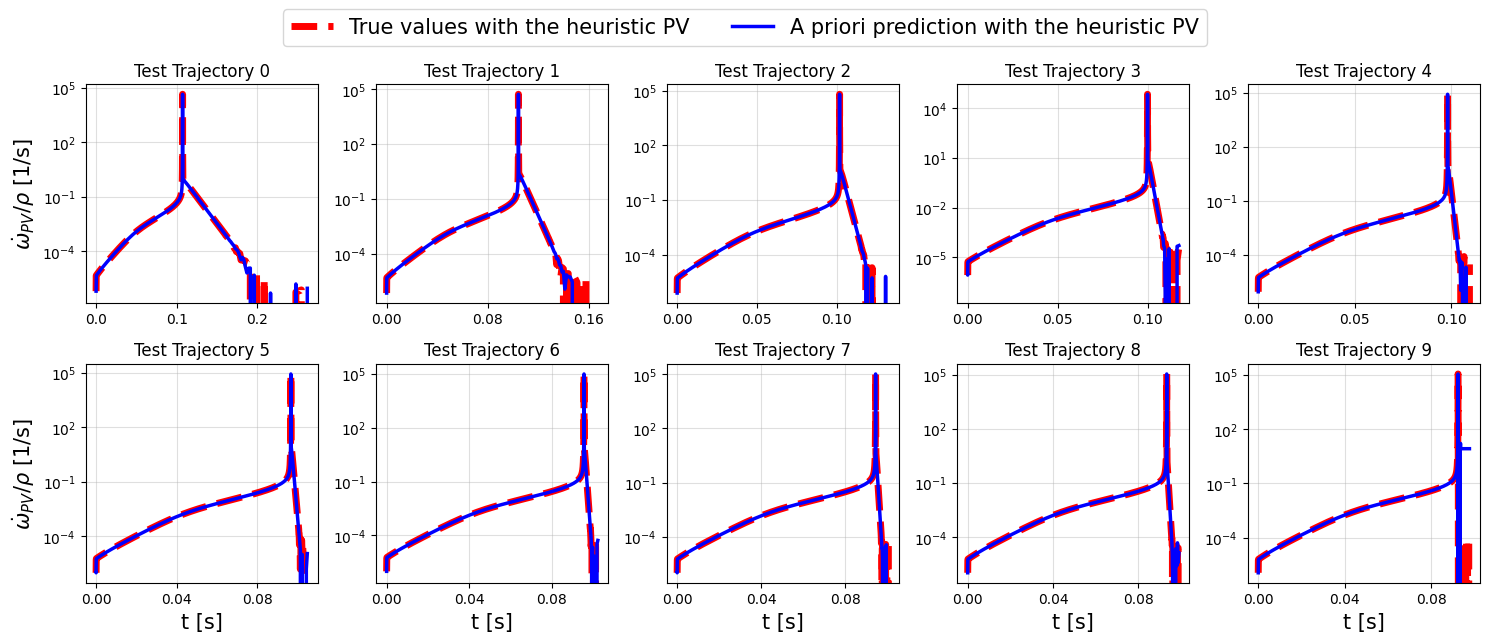

In [8]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled Tabulation/"
name = "Heuristic PV - A priori - Scaled tabulation"
namePdf = "Heuristic PV - A priori - Scaled tabulation.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):  
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    #print(PV_Xu_source_test)
    #print(prediction_test_trajectories[i])
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_Xu_source_test, label="True values with the heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories[i], label="A priori prediction with the heuristic PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

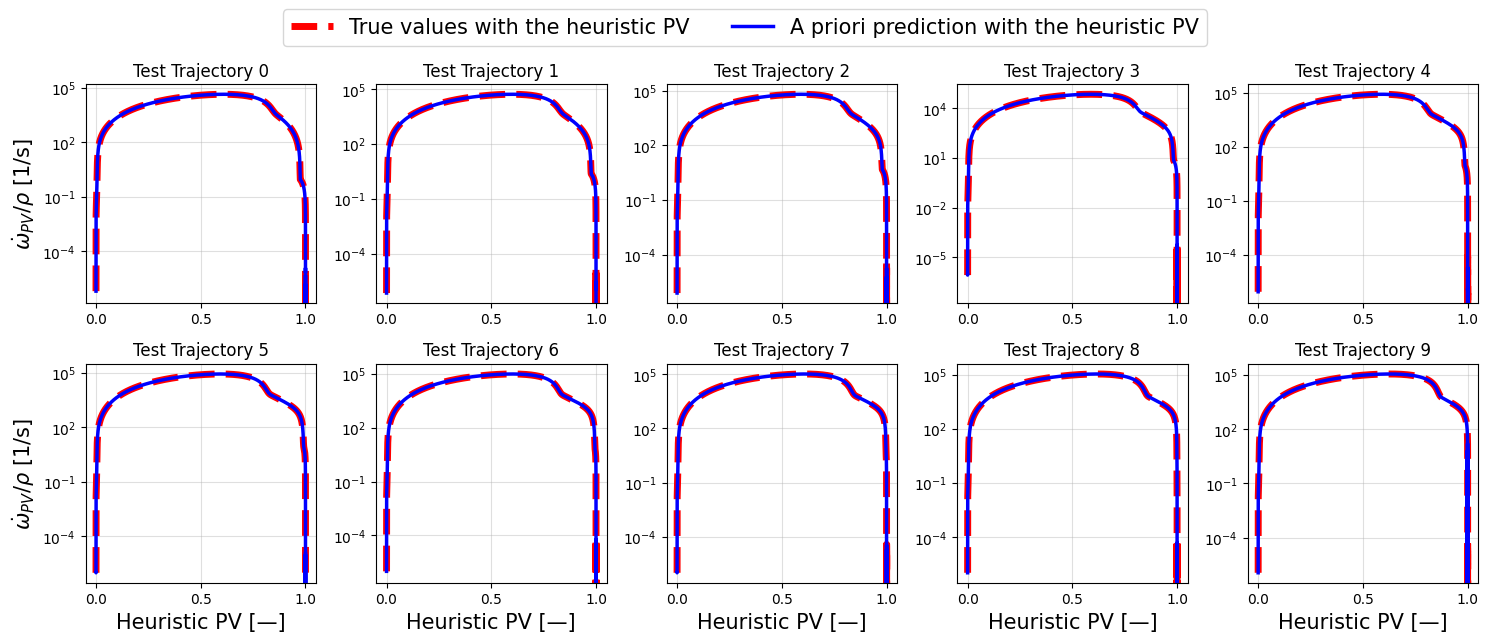

In [22]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled Tabulation/"
name = "Heuristic PV - A priori - PV on x-axis - Scaled tabulation"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories): 

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    #print(PV_Xu_source_test)
    #print(prediction_test_trajectories[i])
    ax = axes[i]
    ax.plot(PV_Xu_test, PV_Xu_source_test, label="True values with the heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(PV_Xu_test, prediction_test_trajectories[i], label="A priori prediction with the heuristic PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.set_xticks([0, 0.5, 1])
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"Heuristic PV [\u2014]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
plt.show()

### A posteriori simulation with heuristic PV (PV of Xu)

In [9]:
class RHS_ODE:
    def __init__(self, mf_data, PV_data, PV_source_data, PV_min, PV_max):
        self.mf_data = mf_data
        self.PV_data = PV_data
        self.PV_source_data = PV_source_data
        self.PV_min = PV_min
        self.PV_max = PV_max

        self.t_pred = []
        self.PV_pred = []
        self.PV_source_pred = []

    def __call__(self, X, t):
        PV_scaled = (X[1] - self.PV_min) / (self.PV_max - self.PV_min)
        predicted = predict_PVsource(X[0], PV_scaled, self.mf_data, self.PV_data, self.PV_source_data)

        self.t_pred.append(t)
        self.PV_pred.append(X[1])
        self.PV_source_pred.append(predicted[0])

        dZdt = np.array([0, predicted[0]])
        return dZdt.ravel()

In [10]:
idx_start_simulation = 0
list_simulations_Xu = []

list_predicted_timesteps_Xu = []
list_predicted_PV_Xu = []
list_predicted_PV_source_Xu = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Date:", date_str)
print("Hour:", time_str)

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_Xu_test[idx_start_simulation,:]
    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    
    rhs = RHS_ODE(mixture_fractions_train, PV_Xu_scaled, PV_Xu_source_train, PV_Xu_test.min(), PV_Xu_test.max())
    
    numerical_solution_Xu, info = odeint(rhs, initial_condition.ravel(), t_coordinates, full_output=1)
    list_simulations_Xu.append(numerical_solution_Xu)

    predicted_timesteps = np.array(rhs.t_pred)
    list_predicted_timesteps_Xu.append(predicted_timesteps)

    predicted_PV = np.array(rhs.PV_pred)
    list_predicted_PV_Xu.append(predicted_PV)

    predicted_source_terms = np.array(rhs.PV_source_pred)
    list_predicted_PV_source_Xu.append(predicted_source_terms)

    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()

    MSE_Xu_test_simulation = mean_squared_error(PV_Xu_test[idx_start_simulation:], numerical_solution_Xu[:,1])

    print(f"MSE for test trajectory {i}: {MSE_Xu_test_simulation}")

Date: 2025-09-04
Hour: 15h55
MSE for test trajectory 0: 0.017097657580751425
MSE for test trajectory 1: 0.02223419478303833
MSE for test trajectory 2: 0.030235981379922183
MSE for test trajectory 3: 0.03292046341298104
MSE for test trajectory 4: 0.0377437291172202
MSE for test trajectory 5: 0.042142266784120336
MSE for test trajectory 6: 0.045611463352035767
MSE for test trajectory 7: 0.048190329139626974
MSE for test trajectory 8: 0.05030799811125601
MSE for test trajectory 9: 0.051802393319907124


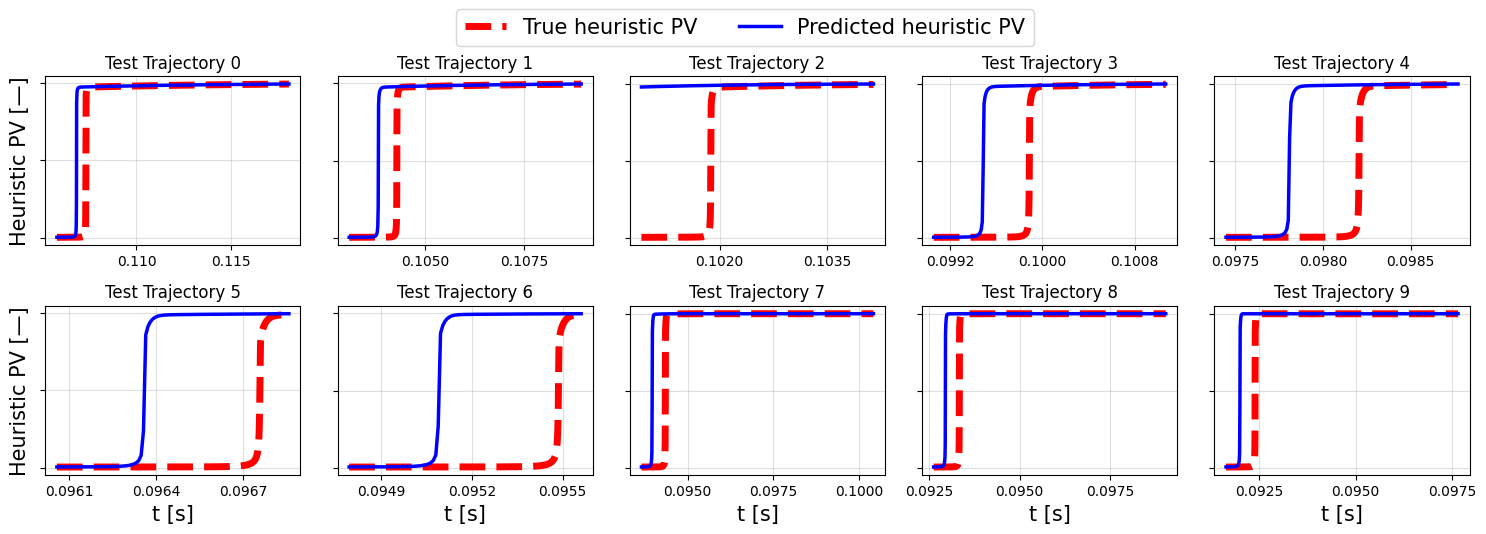

In [ ]:
save = True
zoom = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"

idx_start_simulation = 0

num_test_trajectories = 10
rows, cols = 2, 5 # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        #PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_Xu_test_min = PV_Xu_test.min()
    PV_Xu_test_max = PV_Xu_test.max()

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()

        min_perc = 0.0028
        max_perc = 0.999
        
        max_val = H2O_array.max()
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], (PV_Xu_test[idx_1:idx_99] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_1:idx_99], (list_simulations_Xu[i][idx_1:idx_99,1] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = "blue", linewidth = 2.5)

    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_Xu_test[idx_start_simulation:] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_Xu[i][:,1] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = "blue", linewidth = 2.5)
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized - A posteriori - Heuristic PV - Scaled tabulation{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized - A posteriori - Heuristic PV - Scaled tabulation{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## Optimized PV

In [ ]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
PV_model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        PV_model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = PV_model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()

# Rescale every trajectory from 0 to 1 (each having its own mixture fraction)

df = pd.DataFrame({
    'PV optimized': PV_optimized_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_optimized_scaled'] = df.groupby('mixture_fraction')['PV optimized'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_optimized_scaled = df['PV_optimized_scaled'].to_numpy()

PV_optimized_source_train = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


### A priori assessment closure model with optimized PV

In [14]:
prediction_test_trajectories_optimized = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
    
         
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    vectorized_predict_PVsource = np.vectorize(
        lambda pv_target: predict_PVsource(mixture_fractions_test[i], pv_target, mixture_fractions_train, PV_optimized_scaled, PV_optimized_source_train)
    )

    PV_optimized_source_test_predicted = vectorized_predict_PVsource(PV_optimized_test)
    
    prediction_test_trajectories_optimized.append(PV_optimized_source_test_predicted)

    MSE_optimized_test = mean_squared_error(PV_optimized_source_test, PV_optimized_source_test_predicted)

    print(f"MSE of optimized PV for test trajectory {i}: {MSE_optimized_test}")

MSE of optimized PV for test trajectory 0: 583.7381442478215
MSE of optimized PV for test trajectory 1: 59.542656695161455
MSE of optimized PV for test trajectory 2: 55.068834617232056
MSE of optimized PV for test trajectory 3: 102.20419928578795
MSE of optimized PV for test trajectory 4: 230.71496861538404
MSE of optimized PV for test trajectory 5: 382.9622256195834
MSE of optimized PV for test trajectory 6: 462.40461687932907
MSE of optimized PV for test trajectory 7: 434.49453961700203
MSE of optimized PV for test trajectory 8: 338.58505322172107
MSE of optimized PV for test trajectory 9: 234.9909729264526


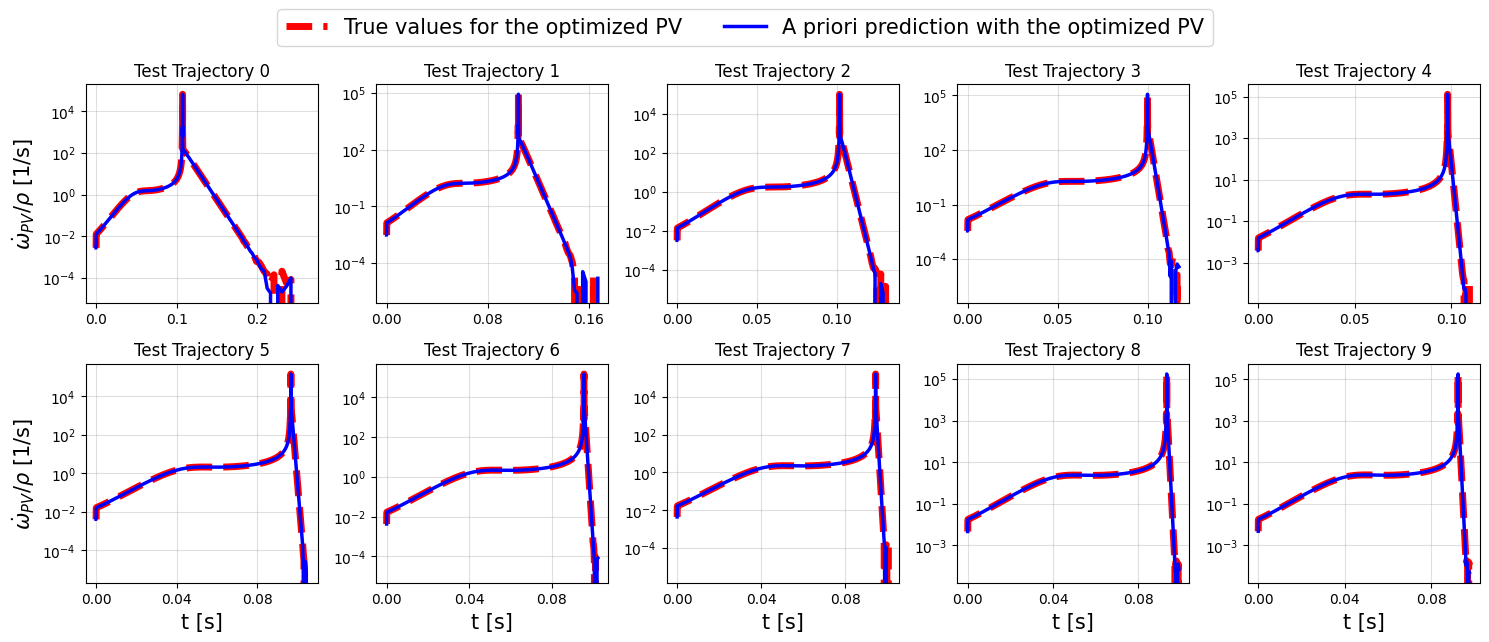

In [15]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"
name = f"Optimized {id_model} - A priori - Scaled abulation.png"
namePdf = f"Optimized {id_model} - A priori - Scaled abulation.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #print(f"\nIteration {i}")
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories_optimized[i], label="A priori prediction with the optimized PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

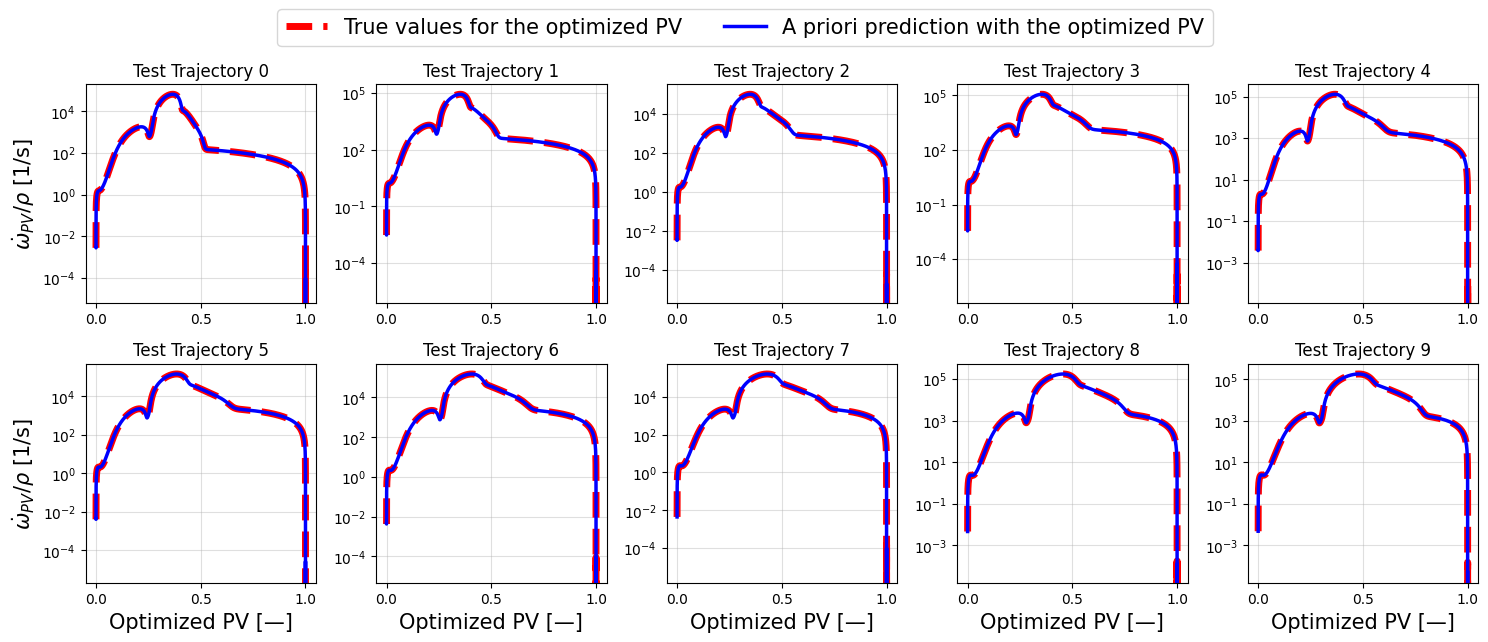

In [25]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"
name = "Optimized PV - A priori - PV on x-axis - Scaled tabulation"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #print(f"\nIteration {i}")

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(PV_optimized_test, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(PV_optimized_test, prediction_test_trajectories_optimized[i], label="A priori prediction with the optimized PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.set_xticks([0, 0.5, 1])
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"Optimized PV [\u2014]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
plt.show()

C:\Windows\Temp\ipykernel_31984\2608380613.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


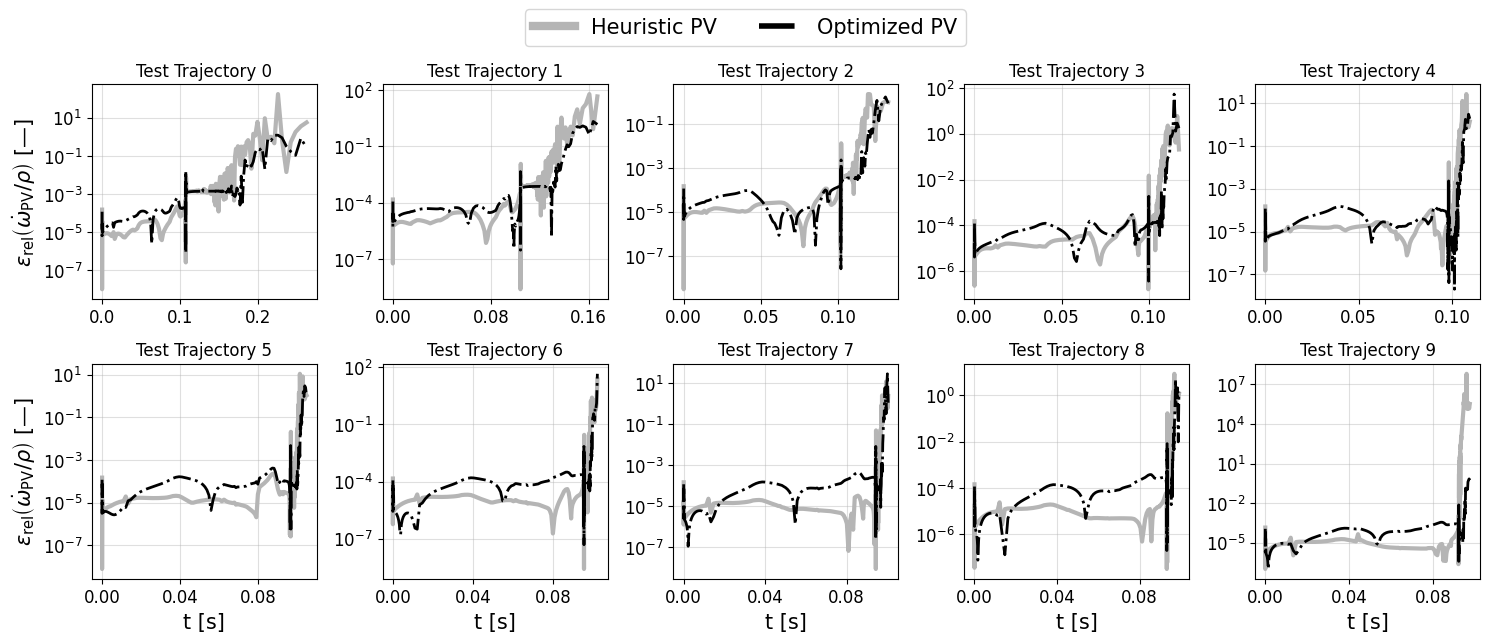

In [16]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"
name = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - Scaled tabulation"
namePdf = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - Scaled tabulation.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[i].flatten())/np.abs(PV_Xu_source_test.flatten())
    relErrorOptimized = np.abs(prediction_test_trajectories_optimized[i].flatten() - PV_optimized_source_test.flatten())/np.abs(PV_optimized_source_test.flatten())
    ax.plot(test_trajectory_time, relativeErrorXu, label = "Heuristic PV", color = greys(0.4), linewidth = 3, linestyle = "-")
    ax.plot(test_trajectory_time, relErrorOptimized, label = "Optimized PV", color = "k", linewidth = 2, linestyle = "-.")
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 2,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## A posteriori simulations

In [17]:
idx_start_simulation = 0
list_simulations_optimized = []

list_predicted_timesteps_optimized = []
list_predicted_PV_optimized = []
list_predicted_PV_source_optimized = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_test[idx_start_simulation,:]
    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    

    rhs = RHS_ODE(
        mixture_fractions_train,
        PV_optimized_scaled,
        PV_optimized_source_train,
        PV_optimized_test.min(),
        PV_optimized_test.max()
    )

    # Run the ODE solver using the wrapped function
    numerical_solution_optimized, info = odeint(
        rhs,
        initial_condition.ravel(),
        t_coordinates,
        full_output=1
    )

    # Save the simulation result
    list_simulations_optimized.append(numerical_solution_optimized)

    predicted_timesteps = np.array(rhs.t_pred)
    list_predicted_timesteps_optimized.append(predicted_timesteps)

    predicted_PV = np.array(rhs.PV_pred)
    list_predicted_PV_optimized.append(predicted_PV)

    predicted_source_terms = np.array(rhs.PV_source_pred)
    list_predicted_PV_source_optimized.append(predicted_source_terms)

    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
    MSE_optimized_test_simulation = mean_squared_error(PV_optimized_test[idx_start_simulation:], numerical_solution_optimized[:, 1])

    print(f"MSE for test trajectory {i}: {MSE_optimized_test_simulation}")

MSE for test trajectory 0: 0.022393883321368973
MSE for test trajectory 1: 0.029940126837378324
MSE for test trajectory 2: 0.05280540659636448
MSE for test trajectory 3: 0.04739120391657011
MSE for test trajectory 4: 0.012085859542177366
MSE for test trajectory 5: 0.06573757768071632
MSE for test trajectory 6: 0.054706831321264804
MSE for test trajectory 7: 0.06151606394089704
MSE for test trajectory 8: 0.06601618092345458
MSE for test trajectory 9: 0.06318788598307142


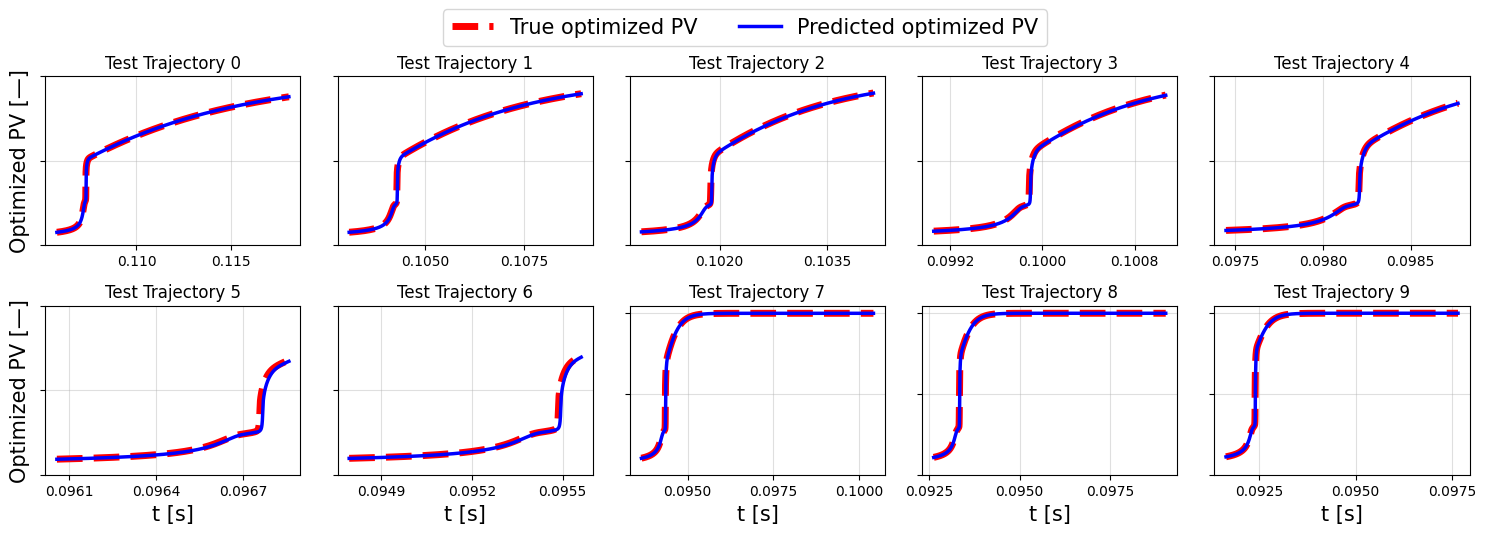

In [19]:
save = True
zoom = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        #PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

    #-(list_simulations_optimized[i][:,1]-PV_min)/(PV_max - PV_min)+1

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()
        
        max_val = H2O_array.max()
        min_perc = 0.0028
        max_perc = 0.999
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], (PV_optimized_test[idx_1:idx_99]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_1:idx_99], (list_simulations_optimized[i][idx_1:idx_99,1]-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized[i][:,1]-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - Scaled tabulation{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - Scaled tabulation{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

### Comparison for one PV trajector the heuristic and optimized PV (full trajectory and zoom in)

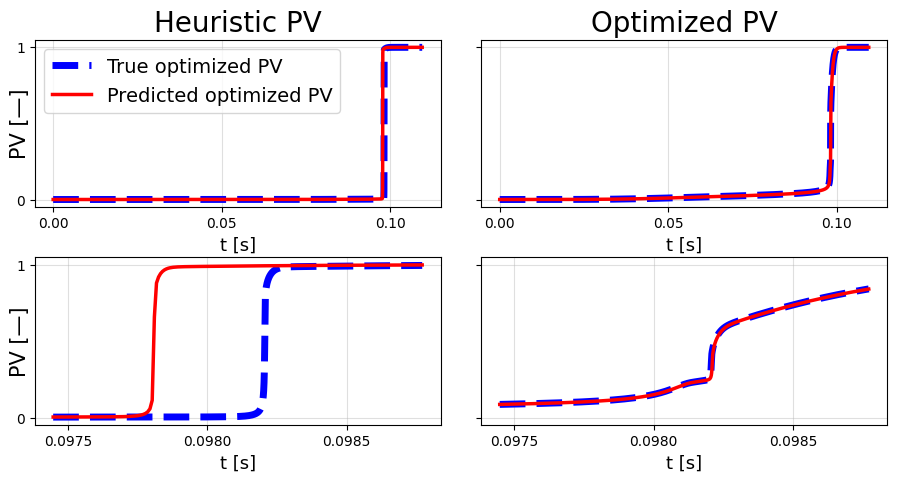

In [ ]:
save = False
zoom = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/"
idx_test = 4  # Use test trajectory 4
idx_start_simulation = 0

# === Prepare figure ===
fig, axes = plt.subplots(2, 2, figsize=(11, 5))
axes = axes.flatten()  # Flatten for easy access

# === Load test data for trajectory 4 ===
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idx_test}'][:], columns=state_space_names)
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test_min = PV_Xu_test.min()
    PV_Xu_test_max = PV_Xu_test.max()

    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idx_test}'][:])

H2O_array = test_trajectory["H2O"].to_numpy()
max_val = H2O_array.max()

# Heuristic Zoom thresholds
min_perc_heur = 0.0028 #0.003
max_perc_heur = 0.999 #0.995
lower_threshold_heur = min_perc_heur * max_val
upper_threshold_heur = max_perc_heur * max_val
idx_1_heur = np.searchsorted(H2O_array, lower_threshold_heur, side='left')
idx_99_heur = np.searchsorted(H2O_array, upper_threshold_heur, side='left')

# Optimized Zoom thresholds
min_perc_opt = 0.0028
max_perc_opt = 0.999
lower_threshold_opt = min_perc_opt * max_val
upper_threshold_opt = max_perc_opt * max_val
idx_1_opt = np.searchsorted(H2O_array, lower_threshold_opt, side='left')
idx_99_opt = np.searchsorted(H2O_array, upper_threshold_opt, side='left')

# === Plotting ===

# 0: Heuristic Full
ax = axes[0]
ax.plot(test_trajectory_time[idx_start_simulation:], (PV_Xu_test[idx_start_simulation:] - PV_Xu_test_min) / (PV_Xu_test_max - PV_Xu_test_min),
        label="True", color="blue", linestyle="--", linewidth=5)
ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_Xu[idx_test][:, 1] - PV_Xu_test_min) / (PV_Xu_test_max - PV_Xu_test_min),
        label="Predicted", color="red", linewidth=2.5)
ax.set_title("Heuristic PV", fontsize = 20)
ax.set_ylabel('PV [—]', fontsize=15, labelpad = -10)
ax.set_xlabel("t [s]", fontsize=13)
ax.grid(True, linestyle='-', alpha=0.4)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_yticks([0, 1])
ax.legend(custom_handles, labels, ncol=1, fontsize=14, frameon=True)

# 1: Optimized Full
ax = axes[1]
ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:] - PV_min) / (PV_max - PV_min),
        label="True optimized PV", color="blue", linestyle="--", linewidth=5)
ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized[idx_test][:, 1] - PV_min) / (PV_max - PV_min),
        label="Predicted optimized PV", color="red", linewidth=2.5)
ax.set_title("Optimized PV", fontsize = 20)
ax.set_xlabel("t [s]", fontsize=13)
ax.grid(True, linestyle='-', alpha=0.4)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_yticks([0, 1])
ax.set_yticklabels("")

# 2: Heuristic Zoom
ax = axes[2]
ax.plot(test_trajectory_time[idx_1_heur:idx_99_heur], (PV_Xu_test[idx_1_heur:idx_99_heur] - PV_Xu_test_min) / (PV_Xu_test_max - PV_Xu_test_min),
        label="True heuristic PV", color="blue", linestyle="--", linewidth=5)
ax.plot(test_trajectory_time[idx_1_heur:idx_99_heur], (list_simulations_Xu[idx_test][idx_1_heur:idx_99_heur, 1] - PV_Xu_test_min) / (PV_Xu_test_max - PV_Xu_test_min),
        label="Predicted heuristic PV", color="red", linewidth=2.5)
ax.set_xlabel("t [s]", fontsize=13)
ax.set_ylabel('PV [—]', fontsize=15, labelpad = -10)
ax.grid(True, linestyle='-', alpha=0.4)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_yticks([0, 1])
ylims = ax.get_ylim()
xlims = ax.get_xlim()

# 3: Optimized Zoom
ax = axes[3]
ax.plot(test_trajectory_time[idx_1_opt:idx_99_opt], (PV_optimized_test[idx_1_opt:idx_99_opt] - PV_min) / (PV_max - PV_min),
        label="True optimized PV", color="blue", linestyle="--", linewidth=5)
ax.plot(test_trajectory_time[idx_1_opt:idx_99_opt], (list_simulations_optimized[idx_test][idx_1_opt:idx_99_opt, 1] - PV_min) / (PV_max - PV_min),
        label="Predicted optimized PV", color="red", linewidth=2.5)
ax.set_xlabel("t [s]", fontsize=13)
ax.grid(True, linestyle='-', alpha=0.4)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_ylim(ylims)
ax.set_xlim(xlims)
ax.set_yticks([0, 1])
ax.set_yticklabels("")

# === Legend ===
handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth(),
           label=label)
    for handle, label in zip(handles, labels)
]

fig.subplots_adjust(
    hspace=0.3,  # Increase vertical space between rows (default ~0.2)
    wspace=0.1    # Decrease horizontal space between columns (default ~0.2)
)

# === Highlight zoom region with rectangle and connecting lines ===

# Coordinates for the zoom frame
x0, x1 = 0.095, 0.102
y0, y1 = -0.03, 1.03

zorder_rect = 10
zorder_line = 11

if zoom:
        # --- Heuristic frame on subplot [0] ---
        rect0 = Rectangle((x0, y0), x1 - x0, y1 - y0,
                        linewidth=1.5, edgecolor='black', facecolor='none', zorder=zorder_rect, linestyle='--')
        axes[0].add_patch(rect0)

        # Compute transformed corners from axes[0] to axes[2]
        p0 = axes[0].transData.transform((x0, y0))  # top-left of rect
        p1 = axes[0].transData.transform((x1, y0))  # top-right of rect

        p0_2 = axes[2].transData.inverted().transform(p0)
        p1_2 = axes[2].transData.inverted().transform(p1)

        # --- Optimized frame on subplot [1] ---
        rect1 = Rectangle((x0, y0), x1 - x0, y1 - y0,
                        linewidth=1.5, edgecolor='black', facecolor='none', zorder=zorder_rect, linestyle='--')
        axes[1].add_patch(rect1)

        p0 = axes[1].transData.transform((x0, y0))  # top-left
        p1 = axes[1].transData.transform((x1, y0))  # top-right

        p0_3 = axes[3].transData.inverted().transform(p0)
        p1_3 = axes[3].transData.inverted().transform(p1)

        fig_coords_p0 = fig.transFigure.inverted().transform(axes[0].transData.transform((x0, y0)))
        fig_coords_p1 = fig.transFigure.inverted().transform(axes[0].transData.transform((x1, y0)))
        fig_coords_q0 = fig.transFigure.inverted().transform(axes[2].transData.transform((xlims[0], ylims[1])))
        fig_coords_q1 = fig.transFigure.inverted().transform(axes[2].transData.transform((xlims[1], ylims[1])))

        # Add lines to the figure
        fig.lines.append(Line2D([fig_coords_p0[0], fig_coords_q0[0]], [fig_coords_p0[1], fig_coords_q0[1]],
                                transform=fig.transFigure, color='black', linewidth=1, zorder=zorder_line))
        fig.lines.append(Line2D([fig_coords_p1[0], fig_coords_q1[0]], [fig_coords_p1[1], fig_coords_q1[1]],
                                transform=fig.transFigure, color='black', linewidth=1, zorder=zorder_line))

        # --- For Optimized connection lines (axes[1] to axes[3]) ---
        fig_coords_p0 = fig.transFigure.inverted().transform(axes[1].transData.transform((x0, y0)))
        fig_coords_p1 = fig.transFigure.inverted().transform(axes[1].transData.transform((x1, y0)))
        fig_coords_q0 = fig.transFigure.inverted().transform(axes[3].transData.transform((xlims[0], ylims[1])))
        fig_coords_q1 = fig.transFigure.inverted().transform(axes[3].transData.transform((xlims[1], ylims[1])))

        fig.lines.append(Line2D([fig_coords_p0[0], fig_coords_q0[0]], [fig_coords_p0[1], fig_coords_q0[1]],
                                transform=fig.transFigure, color='black', linewidth=1, zorder=zorder_line))
        fig.lines.append(Line2D([fig_coords_p1[0], fig_coords_q1[0]], [fig_coords_p1[1], fig_coords_q1[1]],
                                transform=fig.transFigure, color='black', linewidth=1, zorder=zorder_line))



# === Final layout and save ===
#plt.tight_layout()
if save:
    filename = f"PV_comparison_trajectory_{idx_test}_{'zoom' if zoom else ''}.png"
    plt.savefig(pathSave + filename, dpi=300, bbox_inches="tight")
plt.show()

## Visualize what is happening during the 0D simulation which causes error

In [20]:
def linearInterpolation(t, time_array, PV_array, PV_source_array):

    if t < time_array[0]:
        raise ValueError("t is outside the bounds of the time array")
    
    elif  t > time_array[-1]:
        return float(PV_array[-1]), float(PV_source_array[-1])

    for i in range(len(time_array)):
        if t == time_array[i]:
            return float(PV_array[i]), float(PV_source_array[i])

    # Binary search for lower index
    low = 0
    high = len(time_array) - 1

    while low <= high:
        mid = (low + high) // 2
        if time_array[mid] < t:
            low = mid + 1
        else:
            high = mid - 1

    idx_below = high
    idx_above = high + 1

    PV_interpolated = PV_array[idx_below] + (t - time_array[idx_below])/(time_array[idx_above] - time_array[idx_below])*(PV_array[idx_above] - PV_array[idx_below])
    PV_source_interpolated = PV_source_array[idx_below] + (t - time_array[idx_below])/(time_array[idx_above] - time_array[idx_below])*(PV_source_array[idx_above] - PV_source_array[idx_below])

    return float(PV_interpolated), float(PV_source_interpolated)

In [21]:
idx_traj = 4

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idx_traj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    
    PV_Xu_test_4 = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test_4 = PV_Xu_test_4.to_numpy().reshape(-1,1)
    PV_Xu_test_4_scaled = (PV_Xu_test_4 - PV_Xu_test_4.min())/(PV_Xu_test_4.max() - PV_Xu_test_4.min())
    
    PV_optimized_test_4 = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test_4_scaled = (PV_optimized_test_4 - PV_optimized_test_4.min())/(PV_optimized_test_4.max() - PV_optimized_test_4.min())

#test source terms
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idx_traj}'][:], columns = state_space_names)

    PV_Xu_source_test_4 = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test_4 = PV_Xu_source_test_4.to_numpy()
    
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test_4 = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idx_traj}'][:])

t_coordinates = test_trajectory_time.to_numpy().ravel()

time_predicted_Xu = list_predicted_timesteps_Xu[idx_traj]
PV_Xu_predicted_4 = list_predicted_PV_Xu[idx_traj]
PV_Xu_predicted_4_scaled = (PV_Xu_predicted_4 - PV_Xu_test_4.min())/(PV_Xu_test_4.max() - PV_Xu_test_4.min())
PV_source_Xu_predicted_4 = list_predicted_PV_source_Xu[idx_traj]

time_predicted_optimized = list_predicted_timesteps_optimized[idx_traj]
PV_optimized_predicted_4 = list_predicted_PV_optimized[idx_traj]
PV_optimized_predicted_4_scaled = (PV_optimized_predicted_4 - PV_optimized_test_4.min())/(PV_optimized_test_4.max() - PV_optimized_test_4.min())
PV_source_optimized_predicted_4 = list_predicted_PV_source_optimized[idx_traj]

print(linearInterpolation(time_predicted_Xu[150], t_coordinates, PV_Xu_test_4_scaled, PV_Xu_source_test_4))
print(linearInterpolation(time_predicted_optimized[150], t_coordinates, PV_optimized_test_4_scaled, PV_optimized_source_test_4))
    

(0.0030999815694968767, 0.22463185555092186)
(0.008987945591591892, 1.8823195731833637)


C:\Windows\Temp\ipykernel_31984\1867290300.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(PV_interpolated), float(PV_source_interpolated)


In [22]:
PV_Xu_true_4_scaled = np.zeros_like(PV_Xu_predicted_4_scaled)
PV_source_Xu_true_4 = np.zeros_like(PV_source_Xu_predicted_4)

for idx in range(len(PV_Xu_predicted_4_scaled)):
    PV_Xu_true_4_scaled[idx], PV_source_Xu_true_4[idx] = linearInterpolation(time_predicted_Xu[idx], t_coordinates, PV_Xu_test_4_scaled, PV_Xu_source_test_4)

PV_optimized_true_4_scaled = np.zeros_like(PV_optimized_predicted_4_scaled)
PV_source_optimized_true_4 = np.zeros_like(PV_source_optimized_predicted_4)

for idx in range(len(PV_optimized_predicted_4_scaled)):
    PV_optimized_true_4_scaled[idx], PV_source_optimized_true_4[idx] = linearInterpolation(time_predicted_optimized[idx], t_coordinates, PV_optimized_test_4_scaled, PV_optimized_source_test_4)

C:\Windows\Temp\ipykernel_31984\1867290300.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(PV_array[i]), float(PV_source_array[i])
C:\Windows\Temp\ipykernel_31984\1867290300.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(PV_interpolated), float(PV_source_interpolated)
C:\Windows\Temp\ipykernel_31984\1867290300.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(PV_array[-1]), float(PV_source_array[-1])


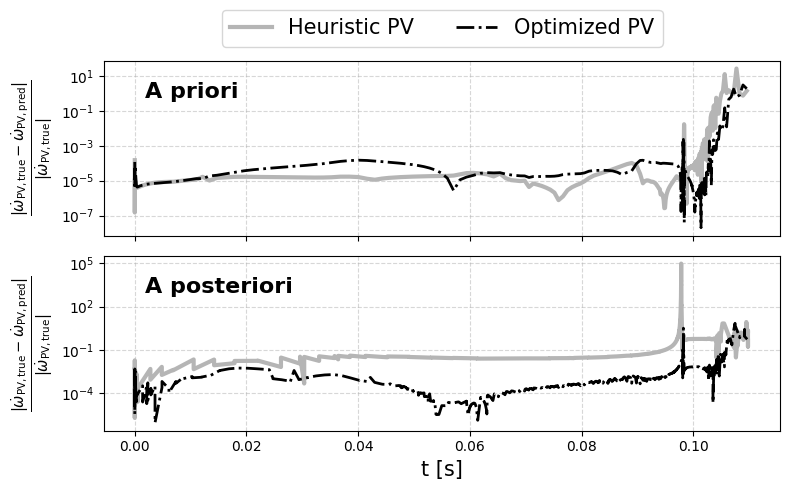

In [23]:
#test source terms
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{4}'][:], columns = state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{4}'][:])

relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[4].flatten())/np.abs(PV_Xu_source_test.flatten())
relErrorOptimized = np.abs(prediction_test_trajectories_optimized[4].flatten() - PV_optimized_source_test.flatten())/np.abs(PV_optimized_source_test.flatten())


save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/A posteriori analysis/"
name = f"Comparison PV source relative a priori and a posteriori - Scaled tabulation"
namePdf = f"Comparison PV source relative a priori and a posteriori - Scaled tabulation.pdf"

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

# --- First subplot ---

sorted_indices_Xu = np.argsort(time_predicted_Xu)
sorted_indices_optimized = np.argsort(time_predicted_optimized)

axs[0].plot(test_trajectory_time, relativeErrorXu, label = "Heuristic PV", color = greys(0.4), linewidth = 3, linestyle = "-")
axs[0].plot(test_trajectory_time, relErrorOptimized, label = "Optimized PV", color = "k", linewidth = 2, linestyle = "-.")

axs[0].set_ylabel(r"$\frac{|\dot{\omega}_{\mathrm{PV, true}} - \dot{\omega}_{\mathrm{PV, pred}}|}{|\dot{\omega}_{\mathrm{PV, true}}|}$", fontsize=15)
axs[0].set_yscale("log")
axs[0].legend(
    fontsize=15,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02)
)
axs[0].grid(True, which="both", linestyle="--", alpha=0.5)

# --- Second subplot ---
axs[1].plot(time_predicted_Xu[sorted_indices_Xu], np.abs((PV_source_Xu_true_4[sorted_indices_Xu] - PV_source_Xu_predicted_4[sorted_indices_Xu]) / PV_source_Xu_true_4[sorted_indices_Xu]),
            label="Heuristic PV", color=greys(0.4), linewidth=3, linestyle="-")
axs[1].plot(time_predicted_optimized[sorted_indices_optimized], np.abs((PV_source_optimized_true_4[sorted_indices_optimized] - PV_source_optimized_predicted_4[sorted_indices_optimized]) / PV_source_optimized_true_4[sorted_indices_optimized]),
            label="Optimized PV", color="k", linewidth=2, linestyle="-.")
axs[1].set_xlabel("t [s]", fontsize=15)
axs[1].set_ylabel(r"$\frac{|\dot{\omega}_{\mathrm{PV, true}} - \dot{\omega}_{\mathrm{PV, pred}}|}{|\dot{\omega}_{\mathrm{PV, true}}|}$", fontsize=15)
axs[1].set_yscale("log")
axs[1].grid(True, which="both", linestyle="--", alpha=0.5)

axs[0].text(0.06, 0.88, "A priori", transform=axs[0].transAxes,
            fontsize=16, fontweight='bold', verticalalignment='top', horizontalalignment='left')

axs[1].text(0.06, 0.88, "A posteriori", transform=axs[1].transAxes,
            fontsize=16, fontweight='bold', verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## Reconstruction of a posteriori simulations

In [ ]:
# Functions to perform the interpolation with tabulation

def get_interp_indices_and_weights(mf_data, mf_limit, PV_target, PV_data):
    """Compute indices and weights for 1D PV interpolation at a given mf."""
    mask_mf = (mf_data == mf_limit)
    PV_mask = PV_data[mask_mf]

    PV_lower = PV_mask[PV_mask <= PV_target]
    PV_upper = PV_mask[PV_mask >= PV_target]

    boolNoBelow = PV_lower.size == 0
    boolNoAbove = PV_upper.size == 0

    if boolNoBelow and boolNoAbove:
        raise ValueError("No PV above or below the target.")
    elif boolNoBelow:
        idx_low = idx_high = np.where(mask_mf)[0][np.argmin(np.abs(PV_mask - PV_target))]
        weight_low, weight_high = 0.0, 1.0
    elif boolNoAbove:
        idx_low = idx_high = np.where(mask_mf)[0][np.argmin(np.abs(PV_mask - PV_target))]
        weight_low, weight_high = 1.0, 0.0
    else:
        PV_low = PV_lower.max()
        PV_high = PV_upper.min()
        idx_low = np.where(mask_mf)[0][np.where(PV_mask == PV_low)[0][0]]
        idx_high = np.where(mask_mf)[0][np.where(PV_mask == PV_high)[0][0]]

        if PV_high == PV_low:
            weight_low, weight_high = 0.5, 0.5
        else:
            weight_low = (PV_high - PV_target) / (PV_high - PV_low)
            weight_high = (PV_target - PV_low) / (PV_high - PV_low)

    return idx_low, idx_high, weight_low, weight_high


def predict_species_all(mf_target, PV_target, mf_data, PV_data, multi_data):
    """Interpolates multiple species from the table for a given (mf, PV) point."""

    unique_mf = np.unique(mf_data)
    mf_below_all = unique_mf[unique_mf <= mf_target]
    mf_above_all = unique_mf[unique_mf >= mf_target]

    if mf_below_all.size == 0 or mf_above_all.size == 0:
        raise ValueError("Target mixture fraction outside bounds.")

    mf_low = mf_below_all.max()
    mf_high = mf_above_all.min()

    # Get indices and weights at mf_low and mf_high
    idx_low_mf_low, idx_high_mf_low, w1_low, w2_low = get_interp_indices_and_weights(mf_data, mf_low, PV_target, PV_data)
    idx_low_mf_high, idx_high_mf_high, w1_high, w2_high = get_interp_indices_and_weights(mf_data, mf_high, PV_target, PV_data)

    # Interpolate species values at mf_low and mf_high
    values_mf_low = w1_low * multi_data[idx_low_mf_low, :] + w2_low * multi_data[idx_high_mf_low, :] 
    values_mf_high = w1_high * multi_data[idx_low_mf_high, :]  + w2_high * multi_data[idx_high_mf_high, :] 

    if mf_high == mf_low:
        return values_mf_low  # or values_mf_high; they should be the same

    # Final interpolation in mf dimension
    final_weights = (mf_target - mf_low) / (mf_high - mf_low)
    result = values_mf_low * (1 - final_weights) + values_mf_high * final_weights

    return result

#### Perform reconstruction of the QoIs using tabulation for both the heuristic and optimized PV

In [25]:
i = 0
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)

QoIs = ["H2O2", "H2O", "H2", "HO2", "N2O", "NO2", "NO", "O2", "OH", "T"]

qoi_train_data = np.hstack([state_space_train[qoi].values[:, np.newaxis] for qoi in QoIs])

reconstruction_Xu = []

for idxSimulations in range(len(list_simulations_Xu)):
    reconstruction_simulation = []

    PV_traj_min = list_simulations_Xu[idxSimulations][:, 1].min()
    PV_traj_max =  list_simulations_Xu[idxSimulations][:, 1].max()

    for idx in range(len(list_simulations_Xu[idxSimulations])):
        PV_predicted_scaled = (list_simulations_Xu[idxSimulations][idx][1] - PV_traj_min)/(PV_traj_max - PV_traj_min)
        reconstruction_simulation.append(predict_species_all(list_simulations_Xu[idxSimulations][idx][0], PV_predicted_scaled,
                                                             mixture_fractions_train, PV_Xu_scaled, qoi_train_data))
    reconstruction_Xu.append(reconstruction_simulation)

reconstruction_Xu = [np.vstack(inner_list) for inner_list in reconstruction_Xu]

In [26]:
reconstruction_optimized = []

for idxSimulations in range(len(list_simulations_optimized)):
    reconstruction_simulation = []

    PV_traj_min = list_simulations_optimized[idxSimulations][:, 1].min()
    PV_traj_max =  list_simulations_optimized[idxSimulations][:, 1].max()

    for idx in range(len(list_simulations_optimized[idxSimulations])):
        PV_predicted_scaled = (list_simulations_optimized[idxSimulations][idx][1] - PV_traj_min)/(PV_traj_max - PV_traj_min)
        reconstruction_simulation.append(predict_species_all(list_simulations_optimized[idxSimulations][idx][0], PV_predicted_scaled,
                                                             mixture_fractions_train, PV_optimized_scaled, qoi_train_data))
    reconstruction_optimized.append(reconstruction_simulation)

reconstruction_optimized = [np.vstack(inner_list) for inner_list in reconstruction_optimized]

#### Visualize the simulations

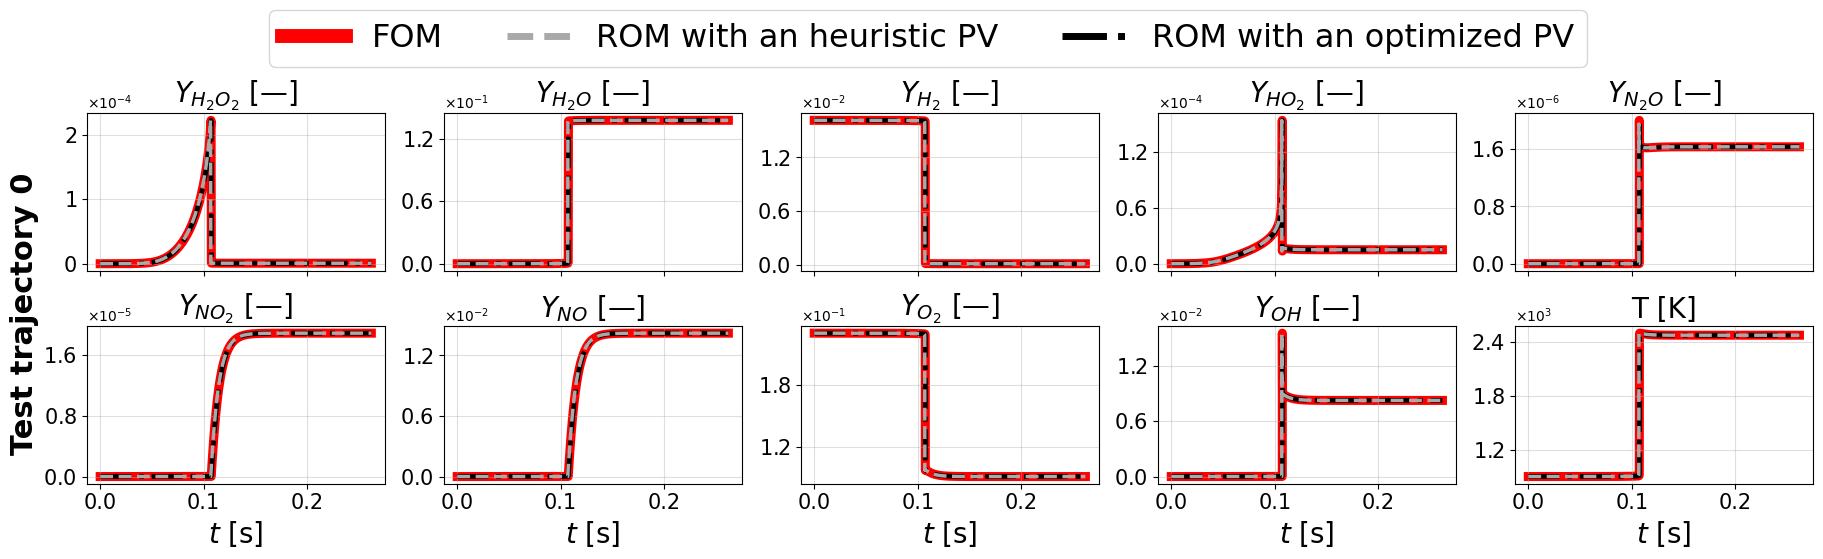

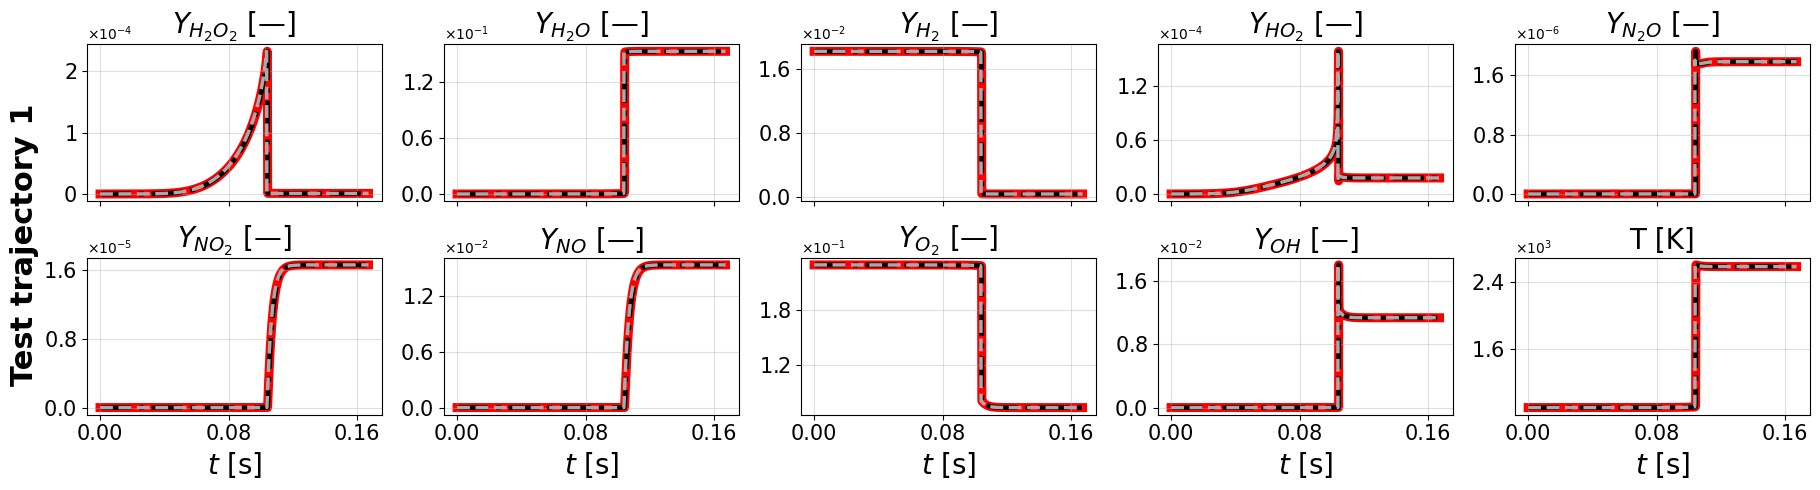

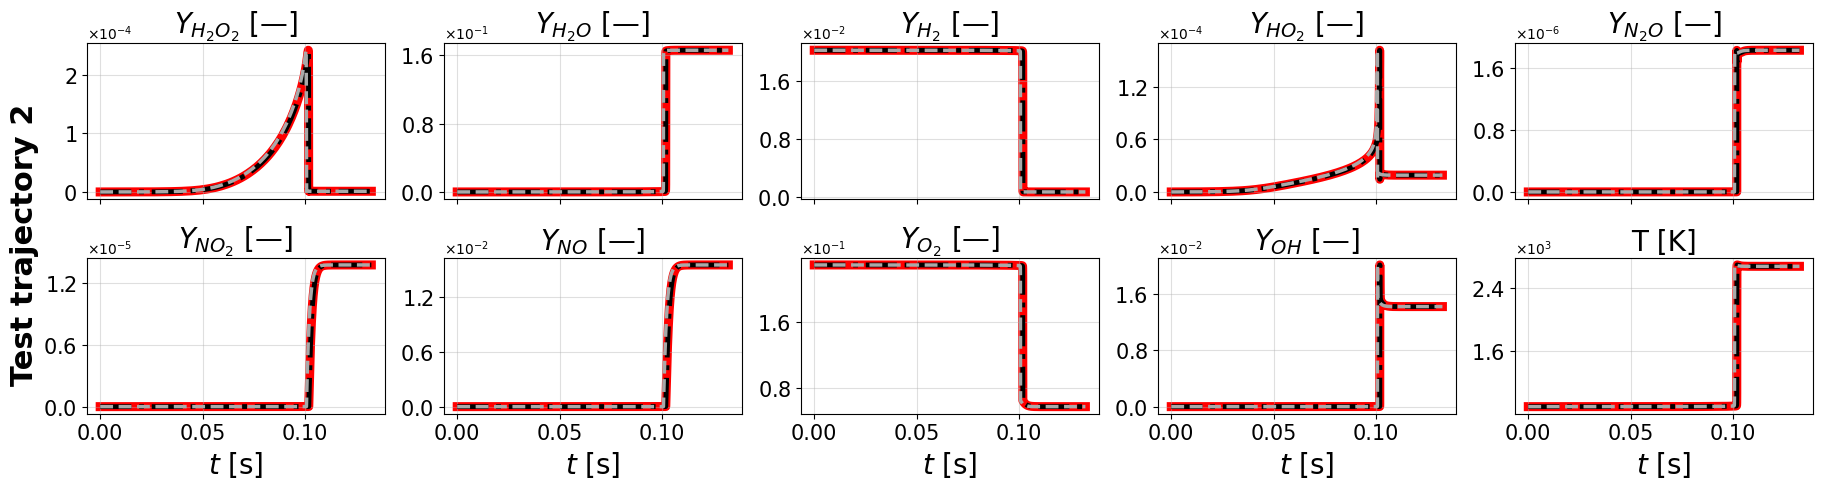

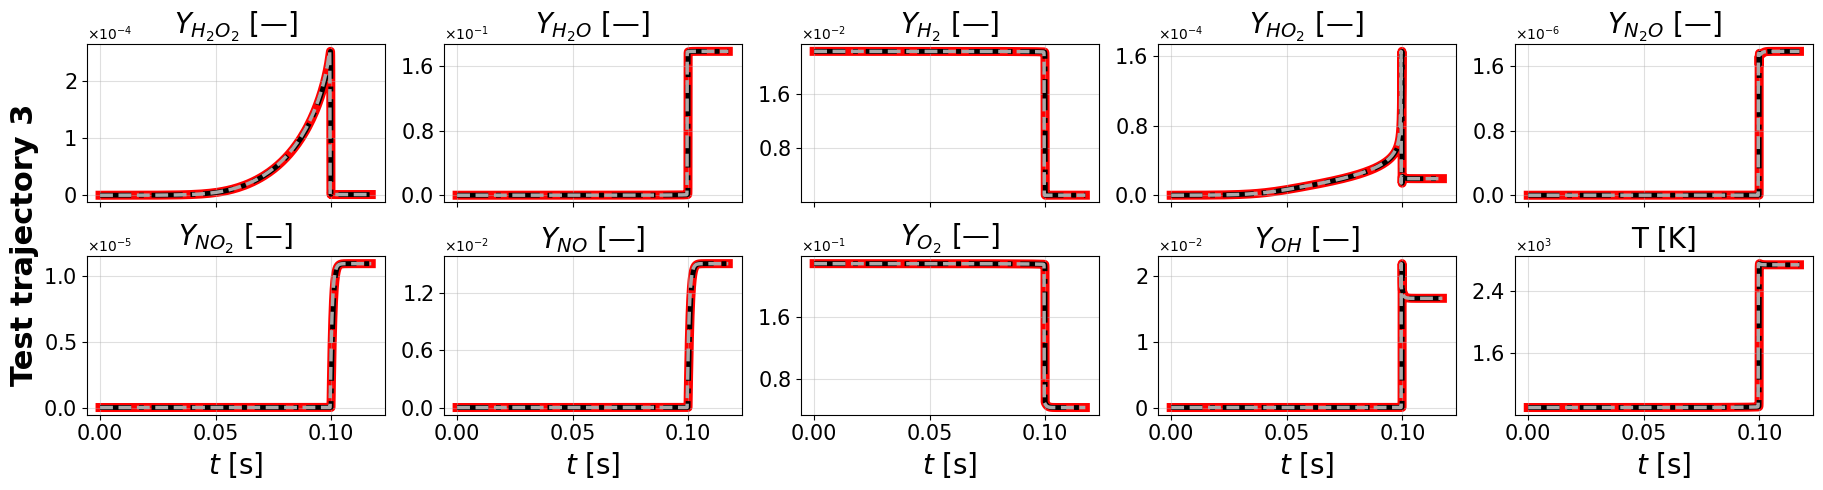

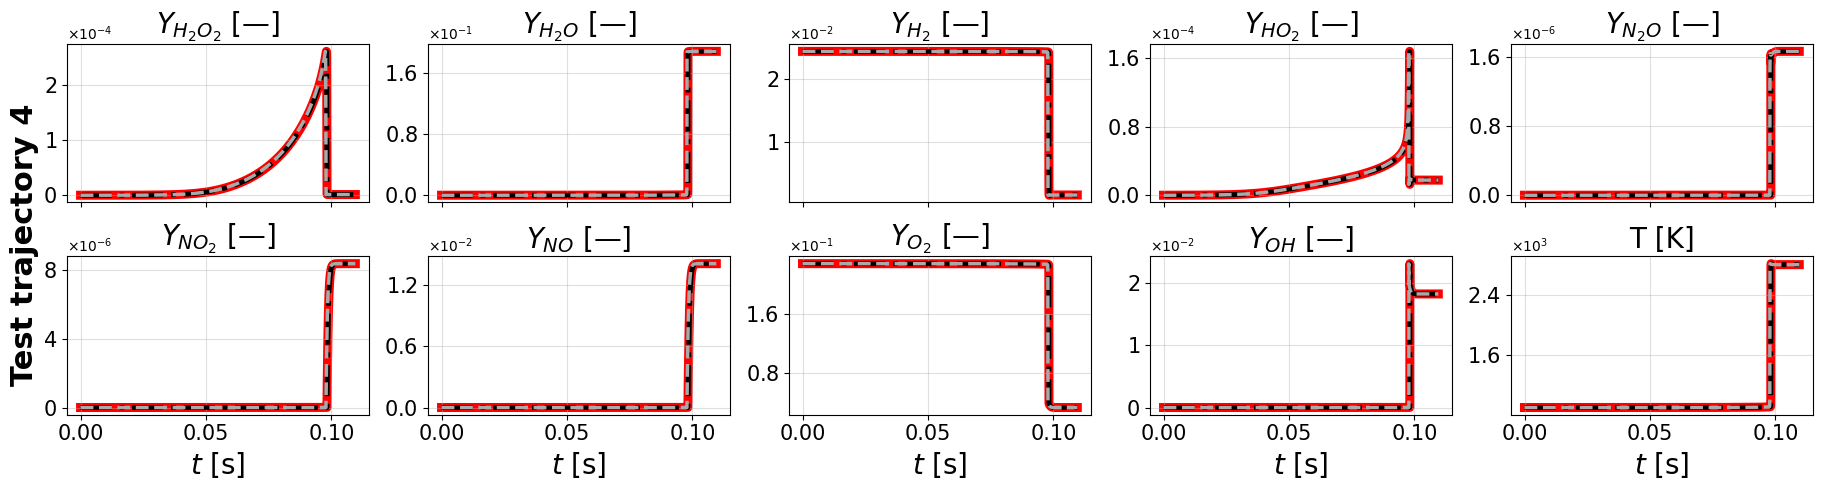

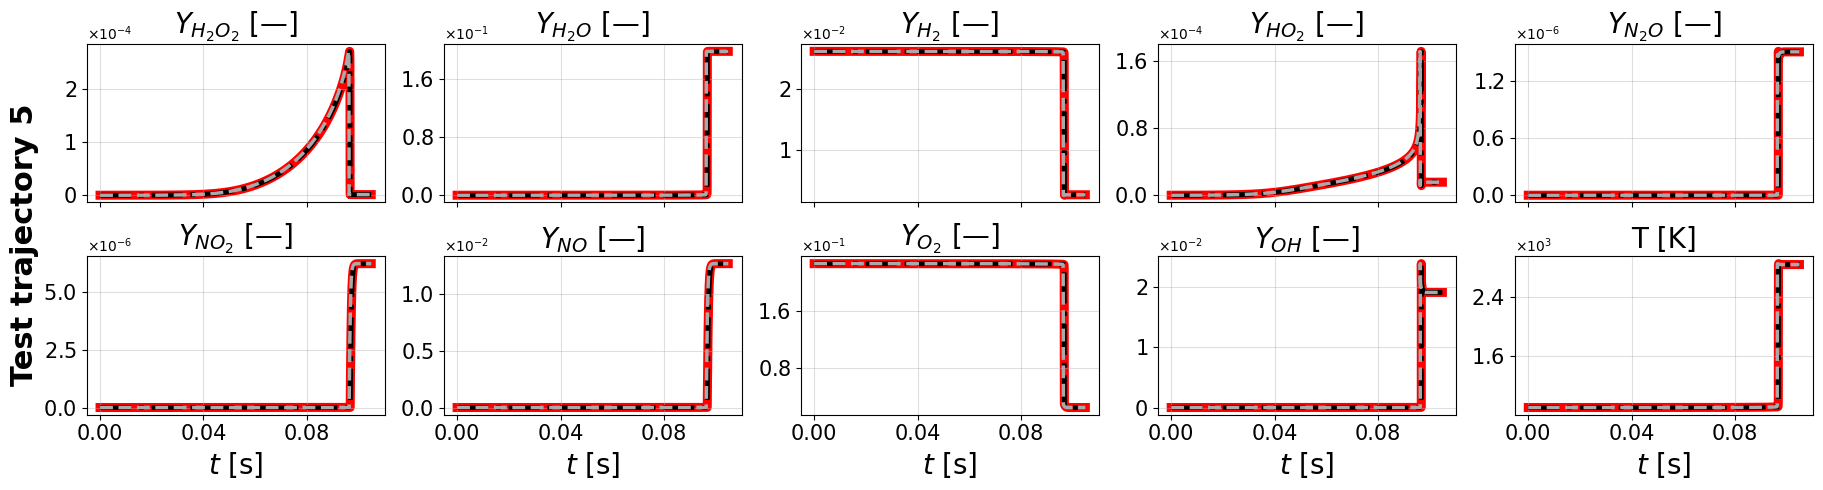

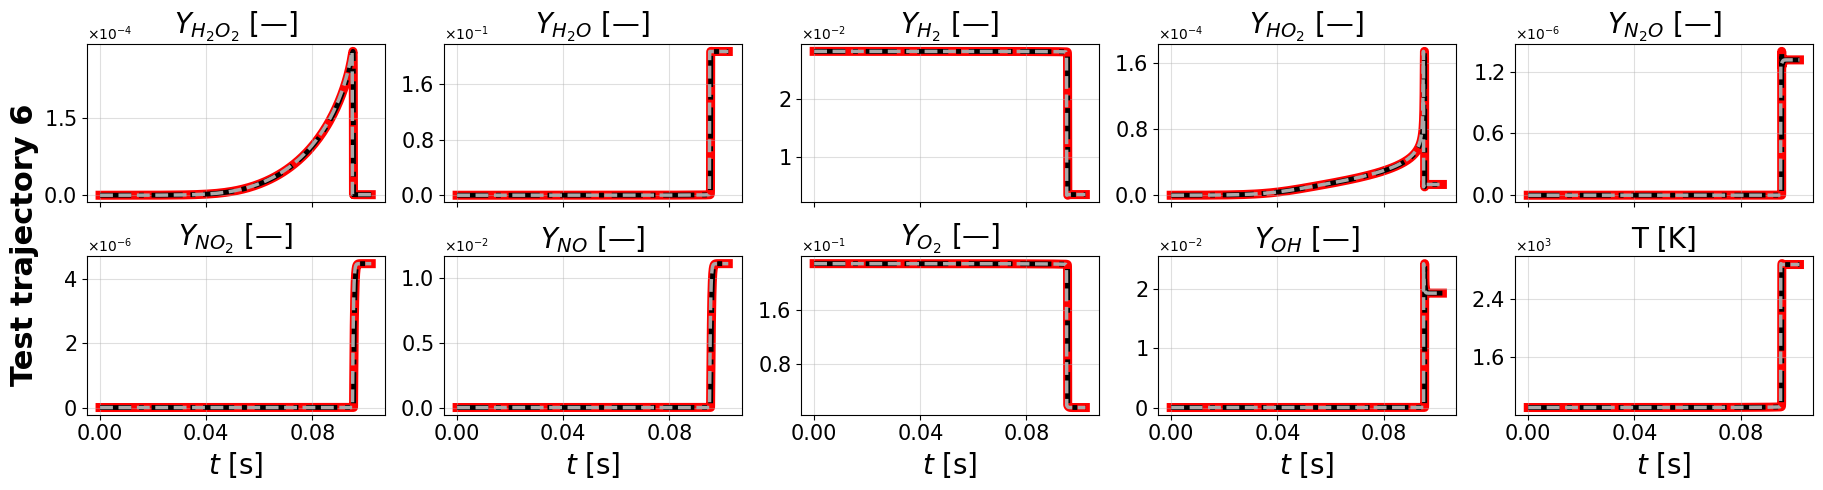

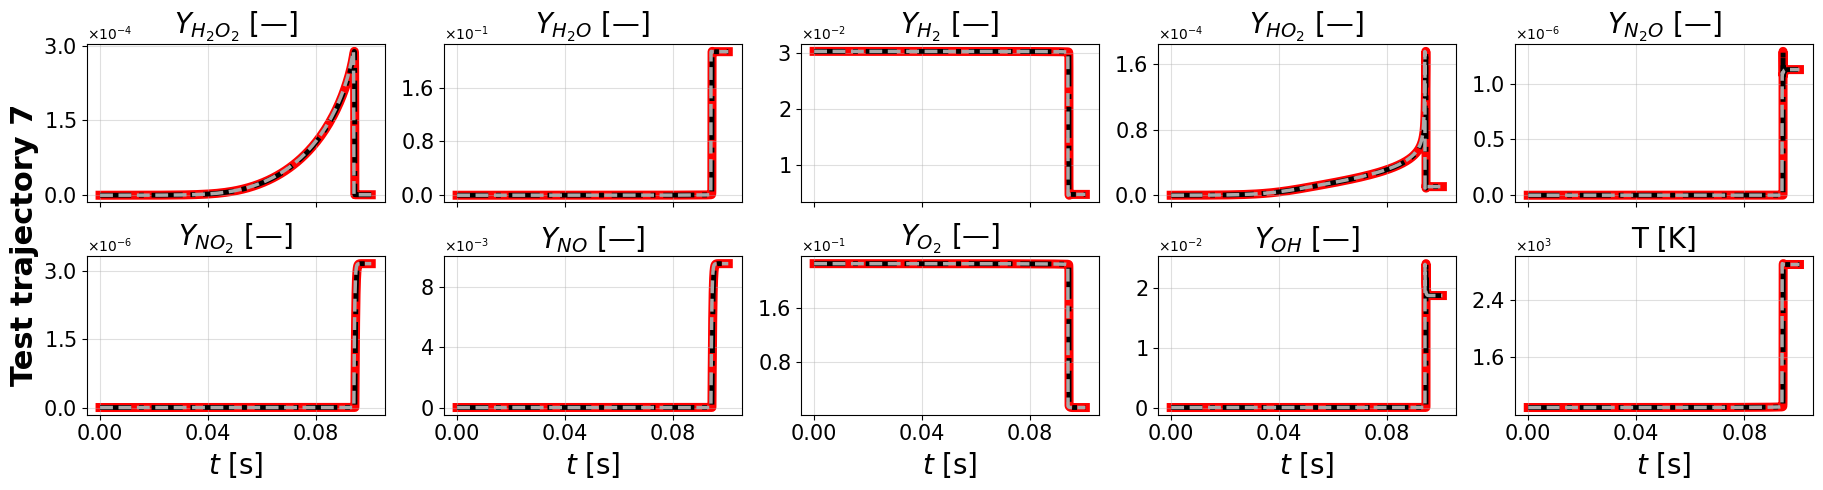

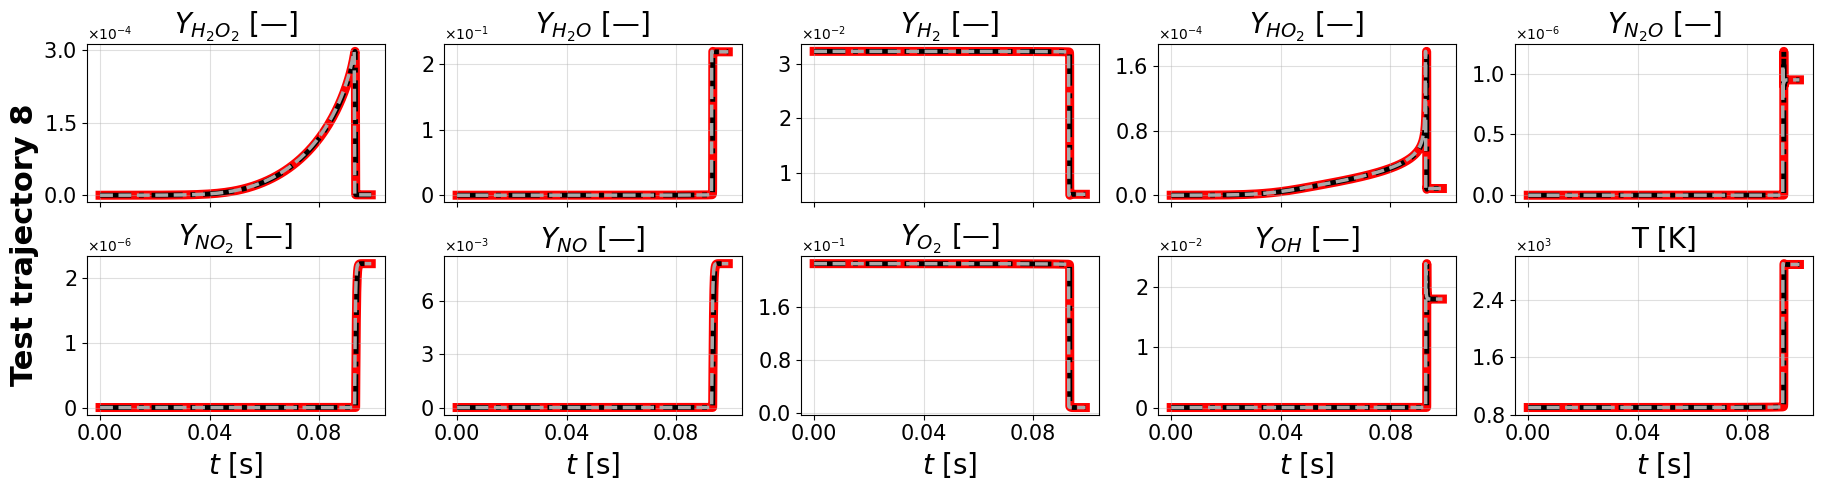

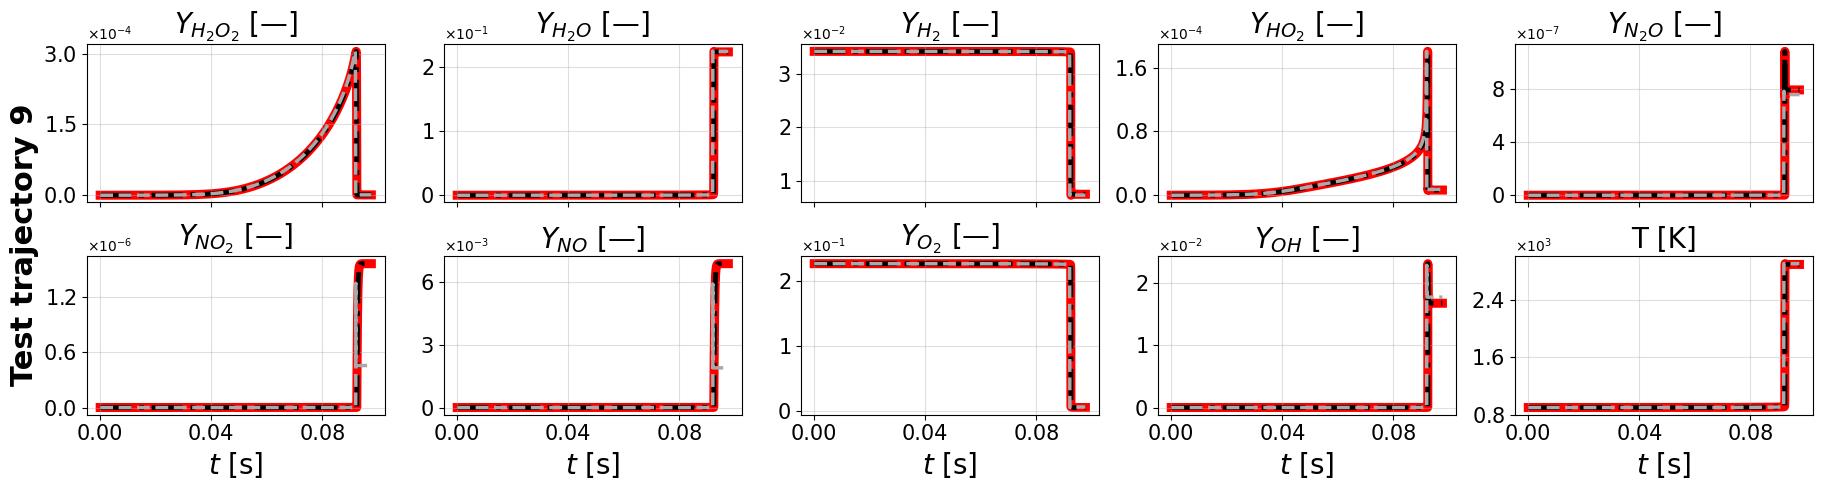

In [27]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/A posteriori/"
name = f"Heuristic vs optimized {id_model} - A posteriori - Scaled tabulation"

Output_species_Latex = [species.replace('2', '_2') for species in QoIs]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    
    for idxQoI in range(len(QoIs)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time[idx_start_simulation:], test_trajectory[QoIs[idxQoI]].iloc[idx_start_simulation:], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time[idx_start_simulation:], reconstruction_Xu[idxSimulation][:, idxQoI], label = "ROM with an heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time[idx_start_simulation:], reconstruction_optimized[idxSimulation][:, idxQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(QoIs[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(QoIs), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with an heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with an optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

### Zoom on the reaction zone

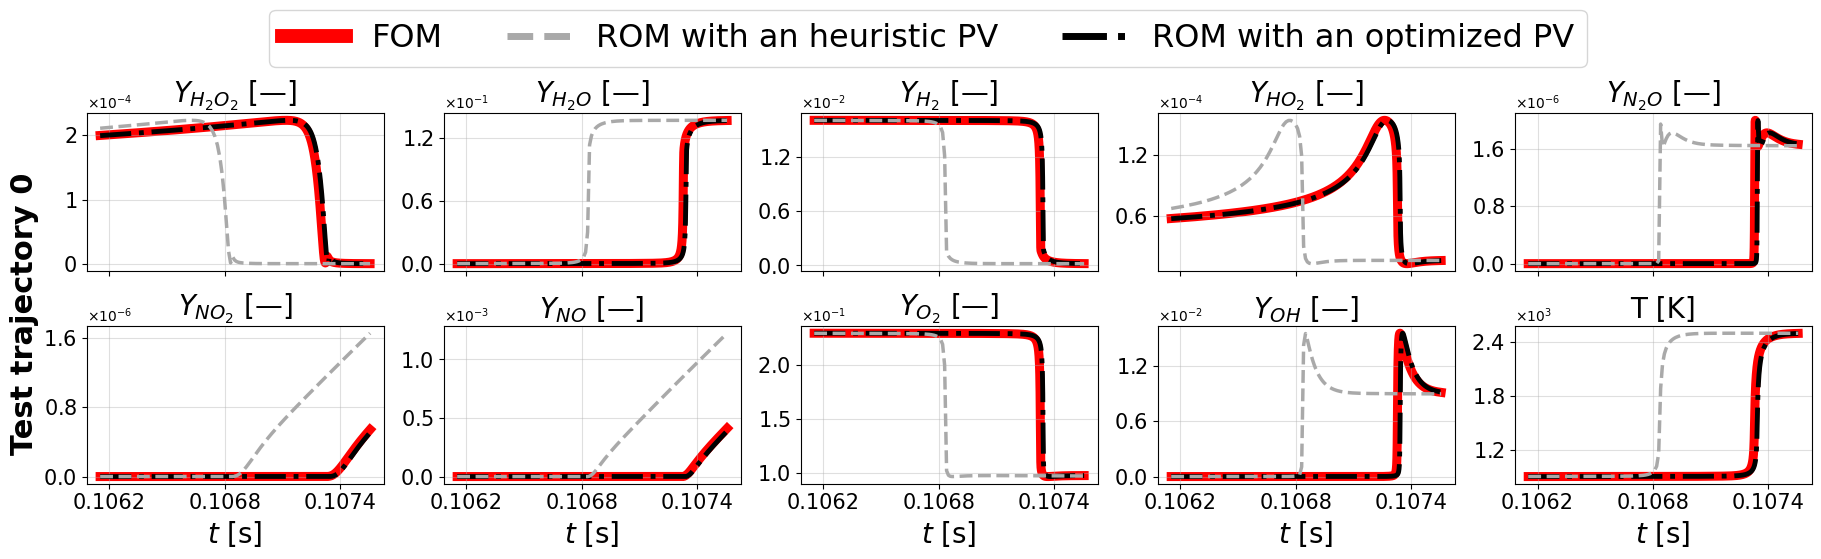

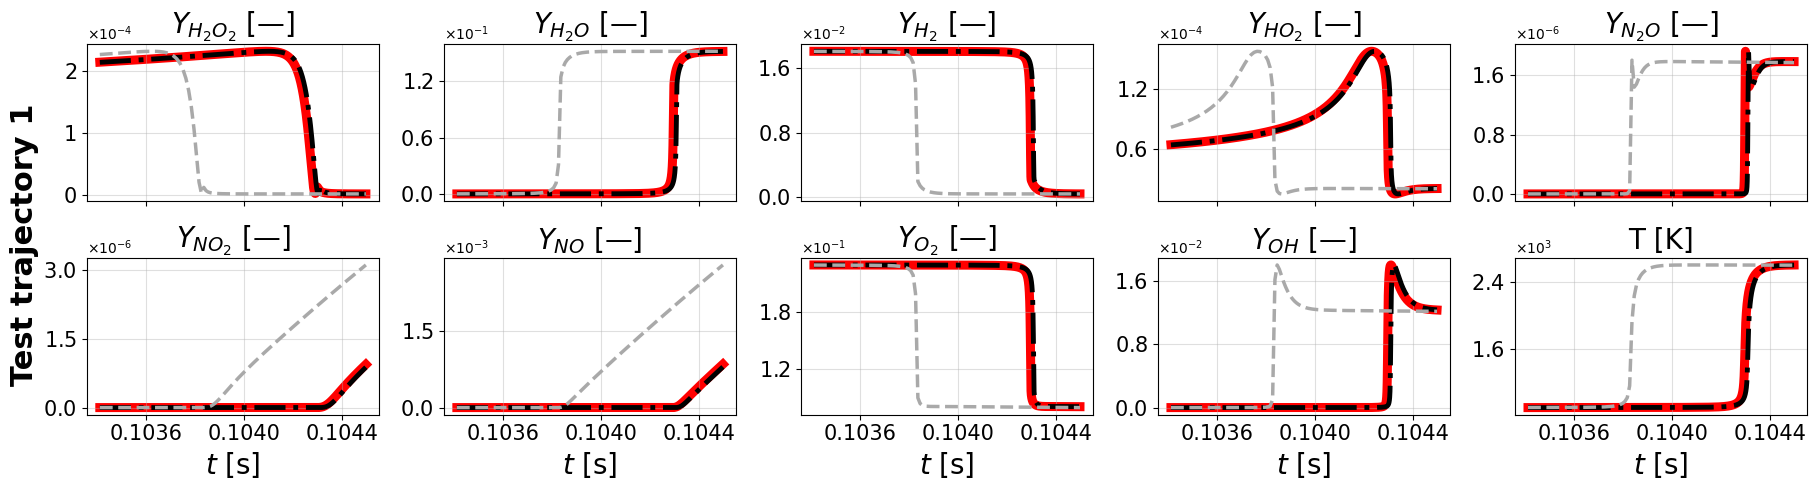

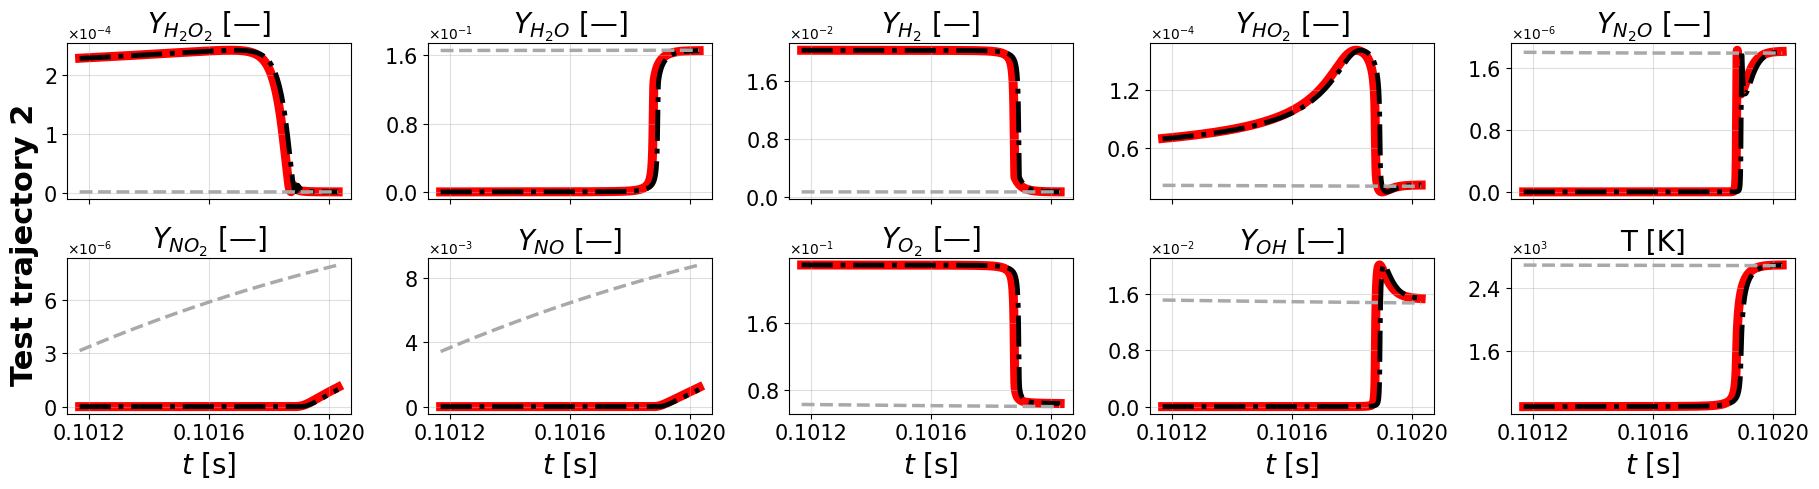

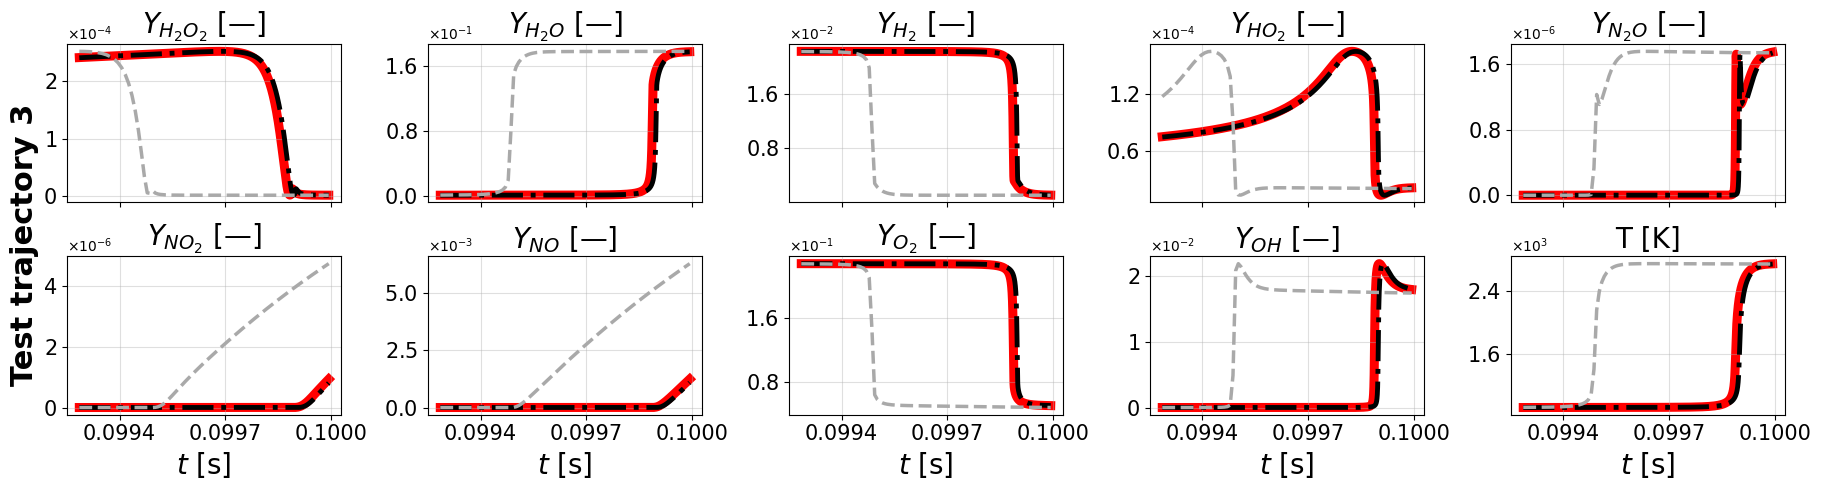

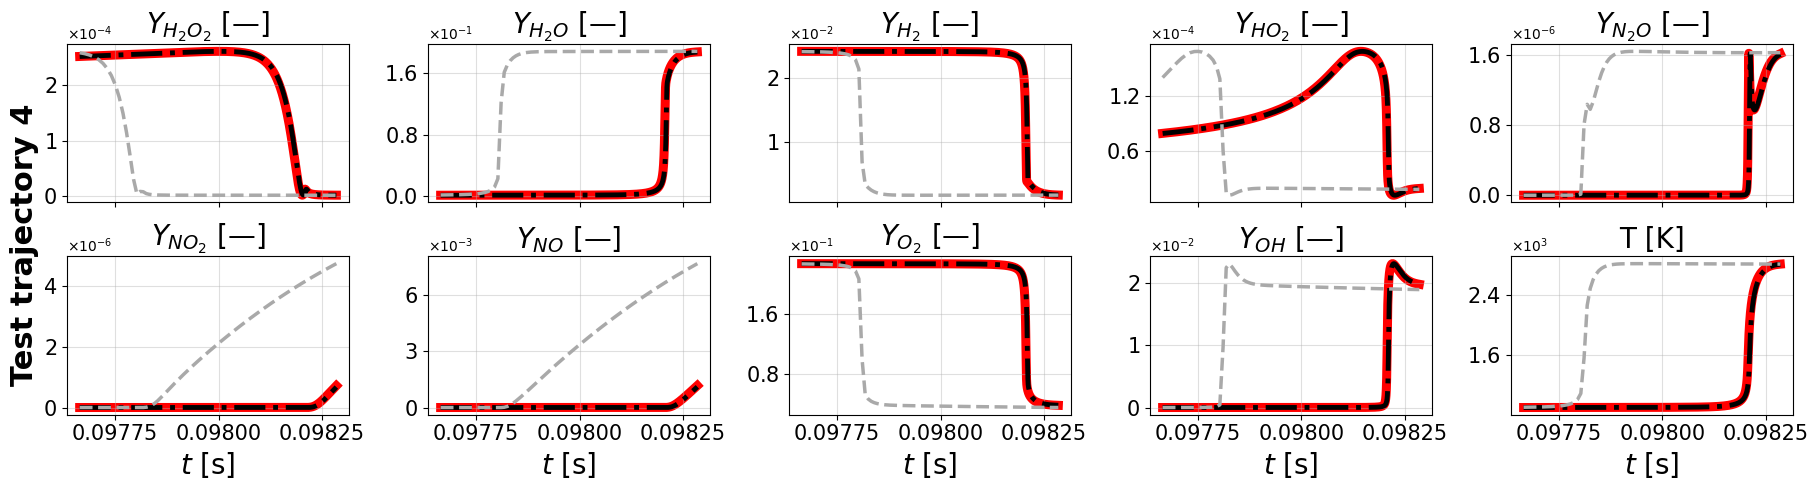

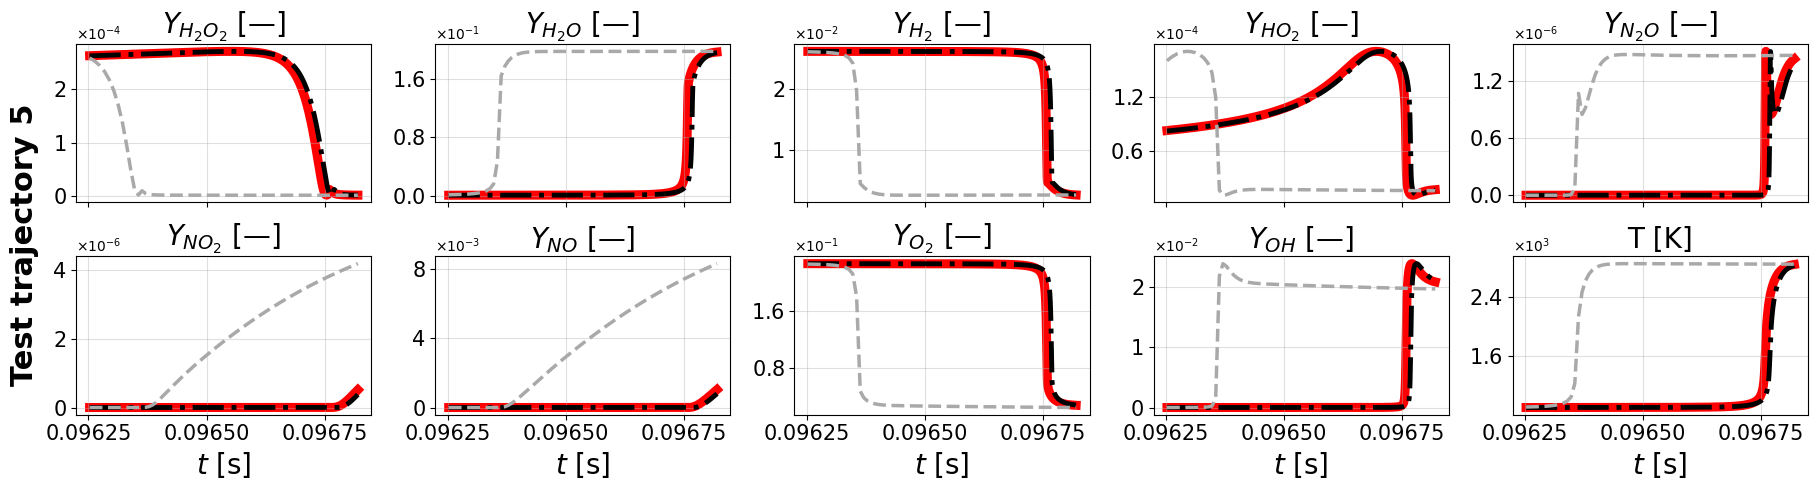

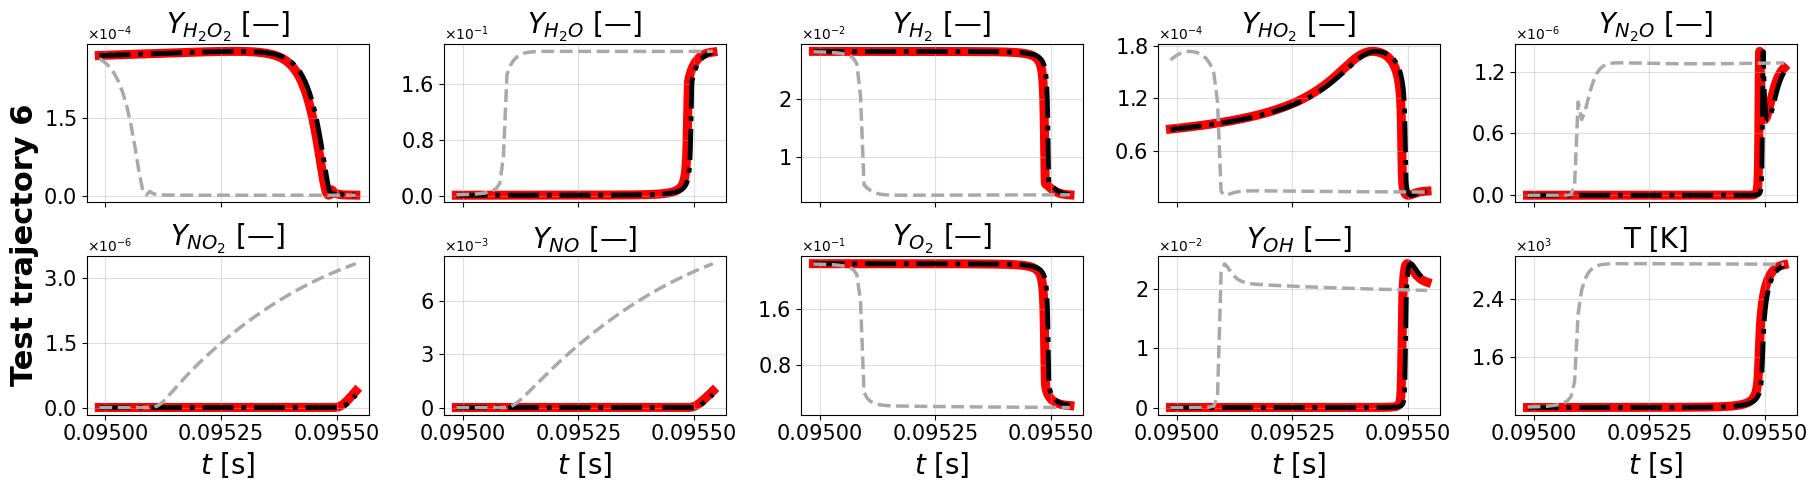

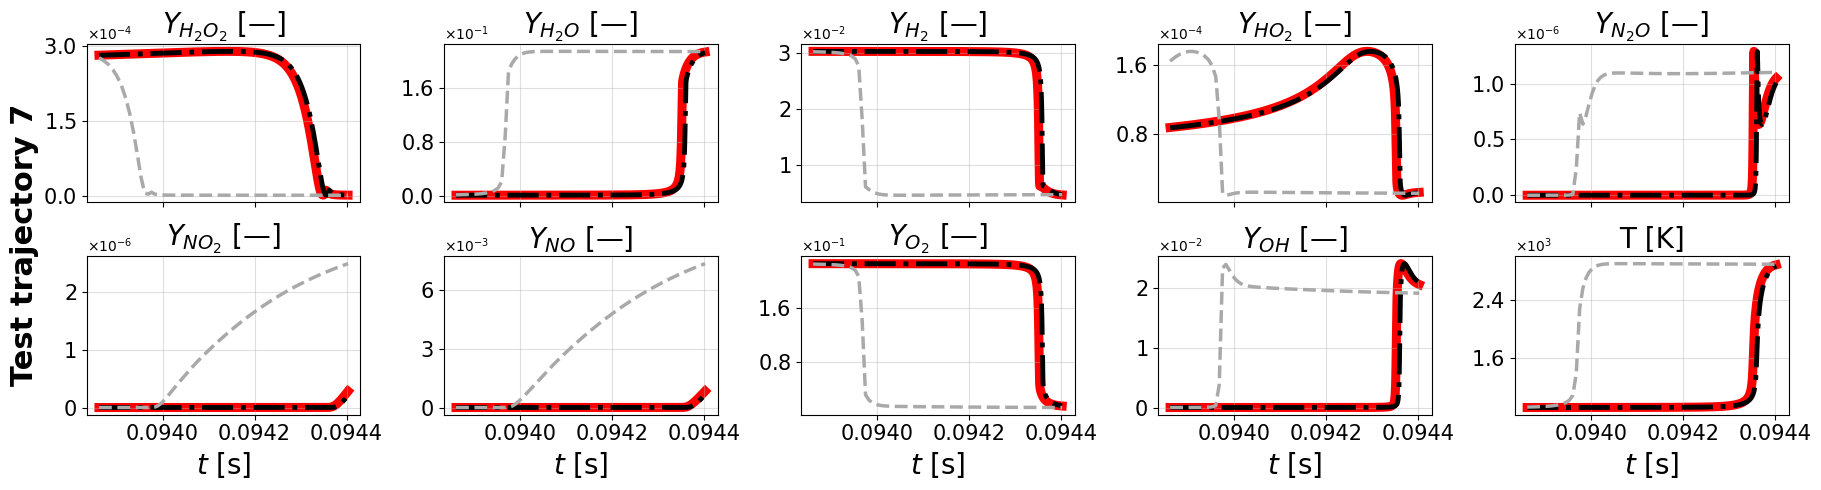

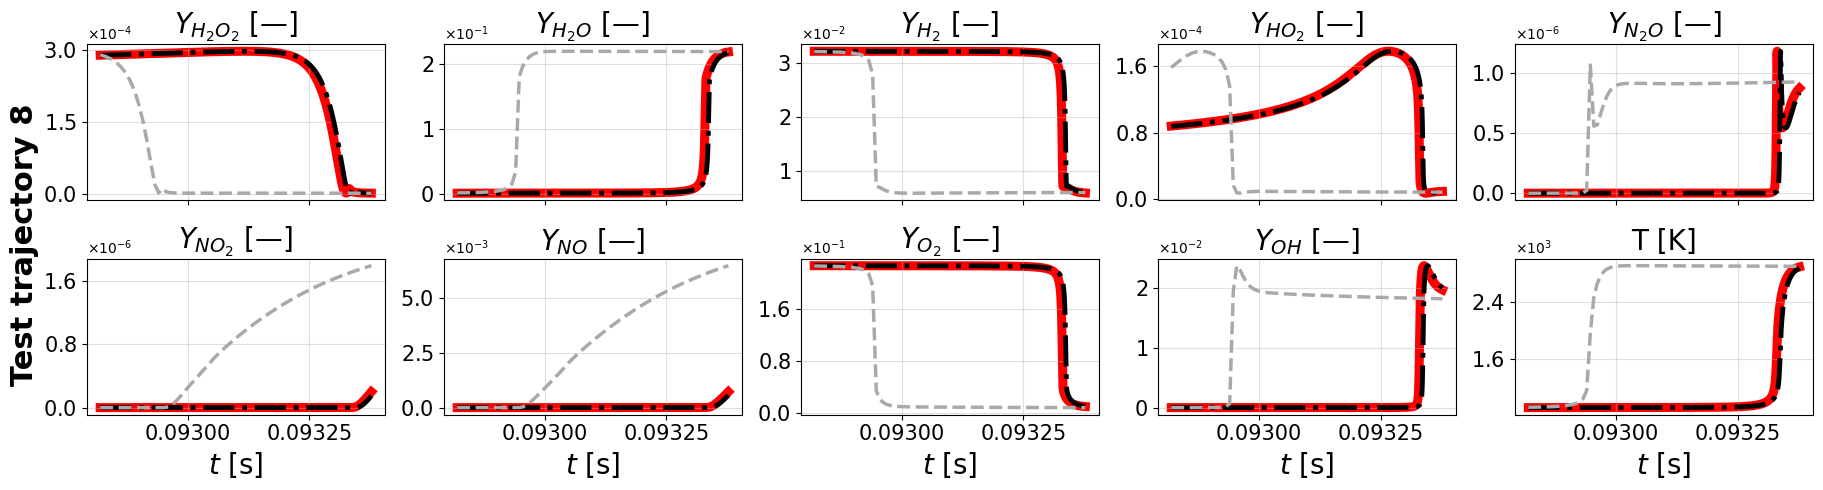

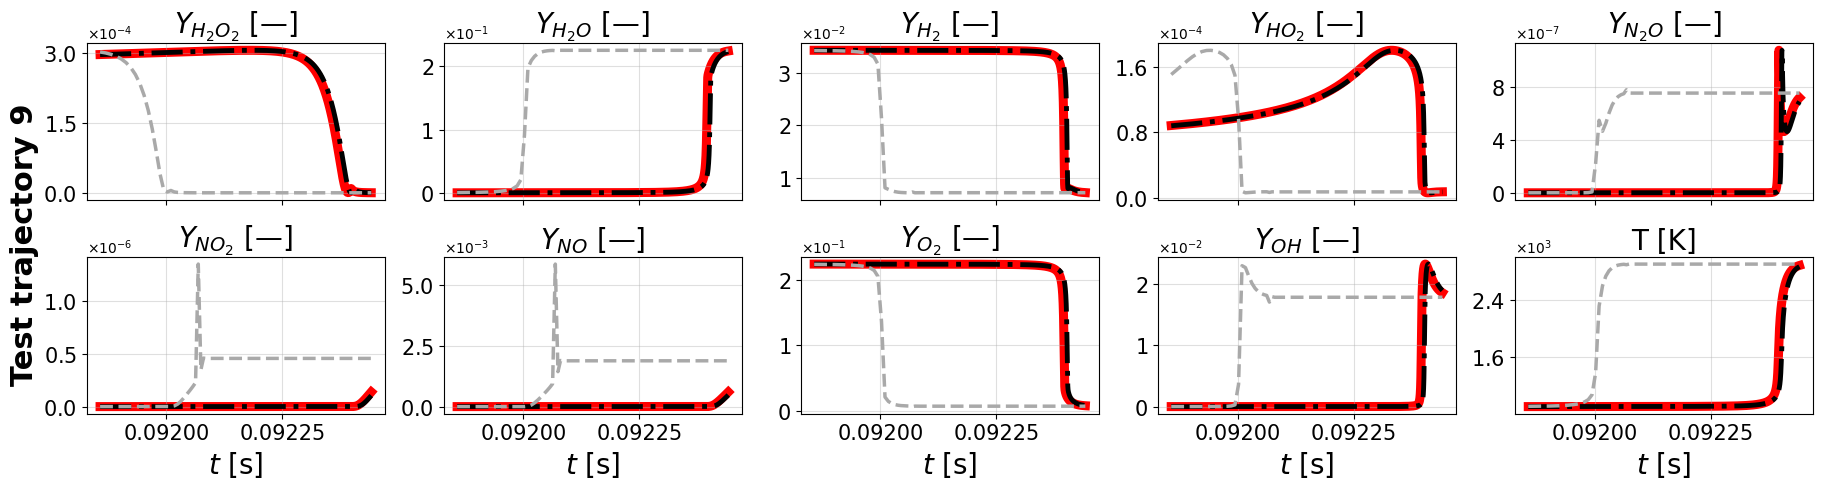

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/A posteriori zoom/"

Output_species_Latex = [species.replace('2', '_2') for species in QoIs]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])

    ##############################################
    # Get the first and last index of the ignition
    ##############################################

    H2O_array = test_trajectory["H2O"].to_numpy()
    
    max_val = H2O_array.max()

    perc_lower = 0.003
    perc_upper = 0.995

    lower_threshold = perc_lower * max_val
    upper_threshold = perc_upper * max_val

    idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
    idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')
    
    for idxQoI in range(len(QoIs)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time[idx_1:idx_99], test_trajectory[QoIs[idxQoI]].iloc[idx_1:idx_99], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time[idx_1:idx_99], reconstruction_Xu[idxSimulation][idx_1:idx_99, idxQoI], label = "ROM with an heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time[idx_1:idx_99], reconstruction_optimized[idxSimulation][idx_1:idx_99, idxQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(QoIs[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(QoIs), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with an heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with an optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout()

    name = f"Heuristic vs optimized {id_model} - A posteriori - Scaled tabulation - zoom {perc_lower}-{perc_upper}"

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()


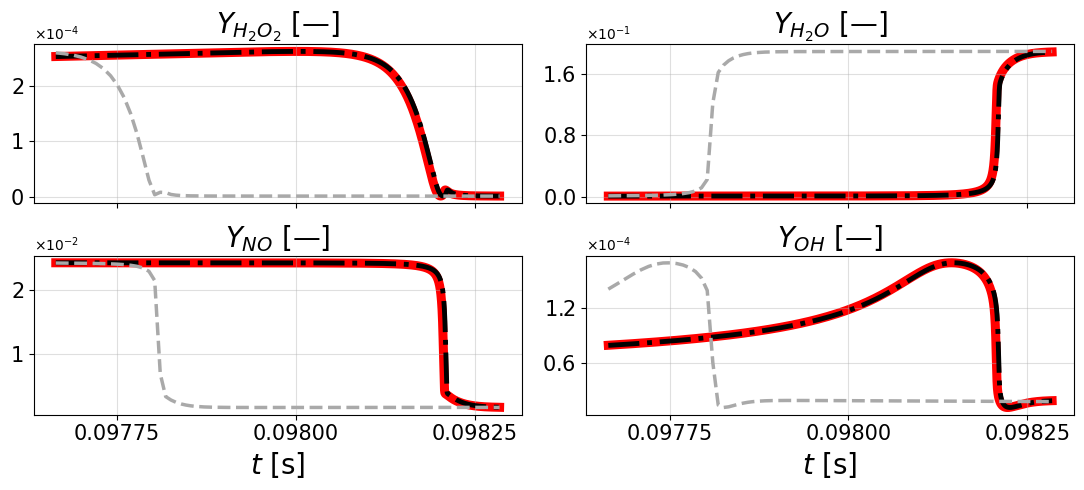

In [ ]:
save = True
zoom = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/4.1 - Scaled tabulation/A posteriori/"
name = f"Heuristic vs optimized {id_model}- A posteriori - Scaled tabulation - PRESENTATION{' - zoom' if zoom else ''}"

smallQoIs = ["H2O2", "H2O","NO", "OH"]

Output_species_Latex = [species.replace('2', '_2') for species in smallQoIs]

idxSimulation = 4

rows, cols = 2, 2

fig, axes = plt.subplots(rows, cols, figsize=(11, 5))
axes = axes.flatten()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])

for idxQoI in range(len(smallQoIs)): 
    ax = axes[idxQoI]

    idxFullQoI = QoIs.index(smallQoIs[idxQoI])
    
    if zoom:
        H2O_array = test_trajectory["H2O"].to_numpy()
    
        max_val = H2O_array.max()

        perc_lower = 0.003
        perc_upper = 0.995

        lower_threshold = perc_lower * max_val
        upper_threshold = perc_upper * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], test_trajectory[QoIs[idxQoI]].iloc[idx_1:idx_99], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
        ax.plot(test_trajectory_time[idx_1:idx_99], reconstruction_Xu[idxSimulation][idx_1:idx_99, idxQoI], label = "ROM with an heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
        ax.plot(test_trajectory_time[idx_1:idx_99], reconstruction_optimized[idxSimulation][idx_1:idx_99, idxQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
        
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], test_trajectory[smallQoIs[idxQoI]].iloc[idx_start_simulation:], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
        ax.plot(test_trajectory_time[idx_start_simulation:], reconstruction_Xu[idxSimulation][:, idxFullQoI], label = "ROM with an heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
        ax.plot(test_trajectory_time[idx_start_simulation:], reconstruction_optimized[idxSimulation][:, idxFullQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
        
    if(QoIs[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
    else:
        ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


    ax.tick_params(axis='x', labelsize=15) 
    ax.tick_params(axis='y', labelsize=15)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

    if(idxQoI>=len(smallQoIs)-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
    else:
        ax.set_xticklabels([])
    
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(True, linestyle='-', alpha=0.4)
        

handles, labels = axes[0].get_legend_handles_labels()
legend_handles = [
    Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
    Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with an heuristic PV'),
    Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with an optimized PV'),
]
if(idxSimulation == 0):
    
    fig.legend(legend_handles, labels,
                loc='upper center', 
                bbox_to_anchor=(0.5, 1.14), 
                ncol=3, 
                fontsize=23,
                frameon=True
            )

plt.tight_layout()

if(save):
    plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")

if(i==0):
    plt.show()

## Extra experiment: A posteriori simulation from the perfect PV trajectory (for the heuristic PV)

In [59]:
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)

QoIs = ["H2O2", "H2O", "H2", "HO2", "N2O", "NO2", "NO", "O2", "OH", "T"]

qoi_train_data = np.hstack([state_space_train[qoi].values[:, np.newaxis] for qoi in QoIs])

reconstruction_Xu_fromTruePV = []

for idxSimulation in range(num_test_trajectories):

    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

    reconstruction_simulation = []
    for idx in range(len(PV_Xu_test)):
        reconstruction_simulation.append(predict_species_all(mixture_fractions_test[idxSimulation], PV_Xu_test[idx], mixture_fractions_train, PV_Xu_train, qoi_train_data))
    reconstruction_Xu_fromTruePV.append(reconstruction_simulation)

reconstruction_Xu_fromTruePV = [np.vstack(inner_list) for inner_list in reconstruction_Xu_fromTruePV]

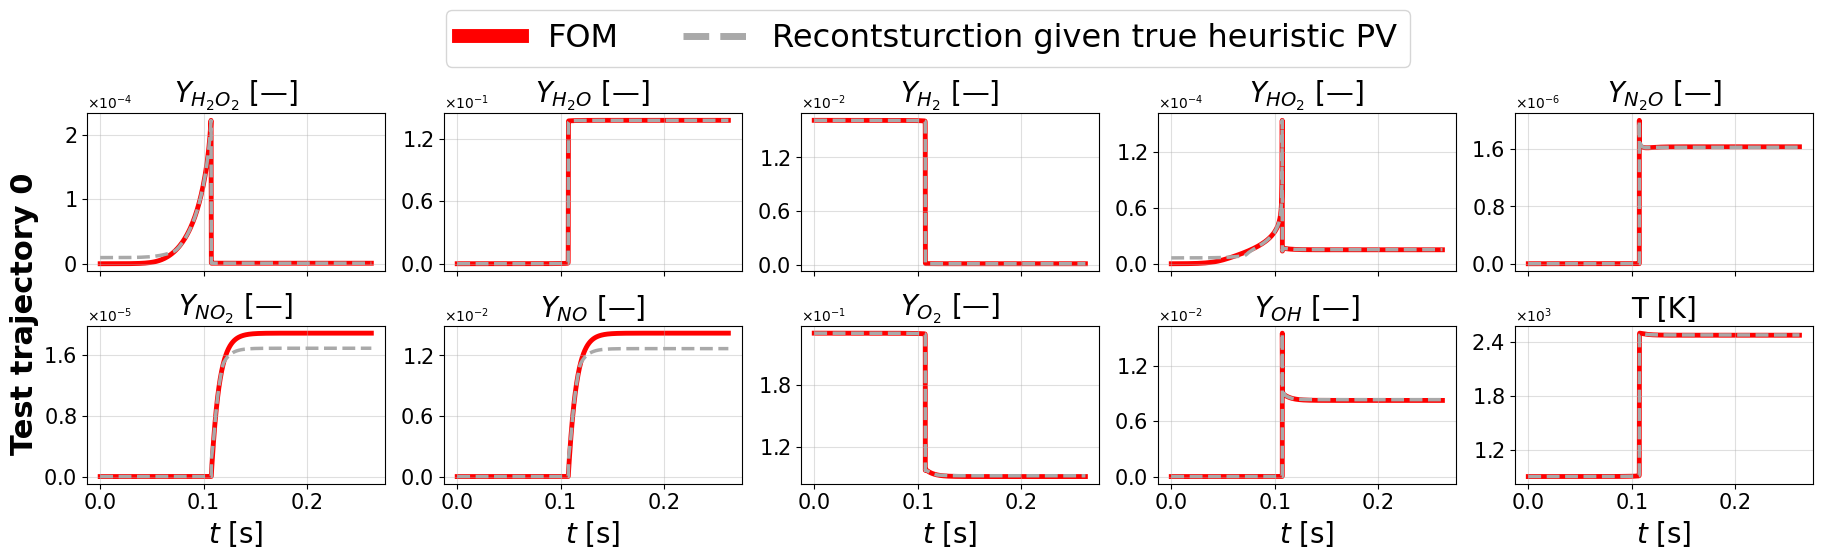

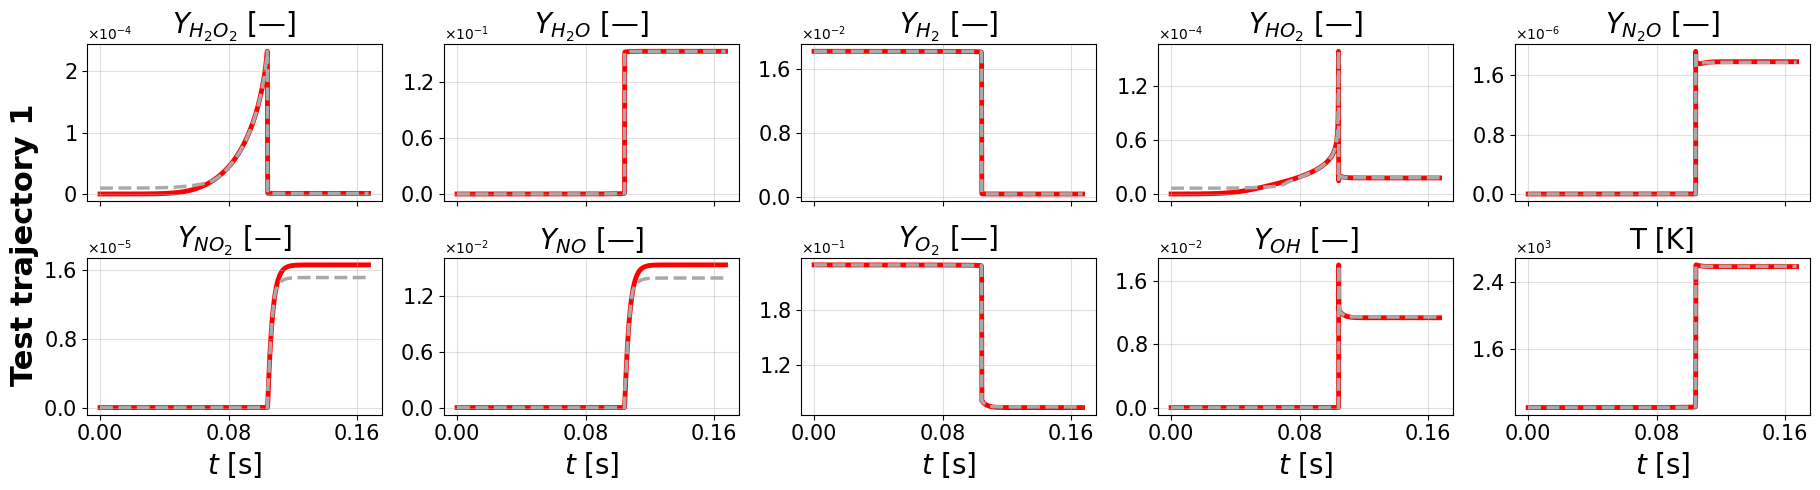

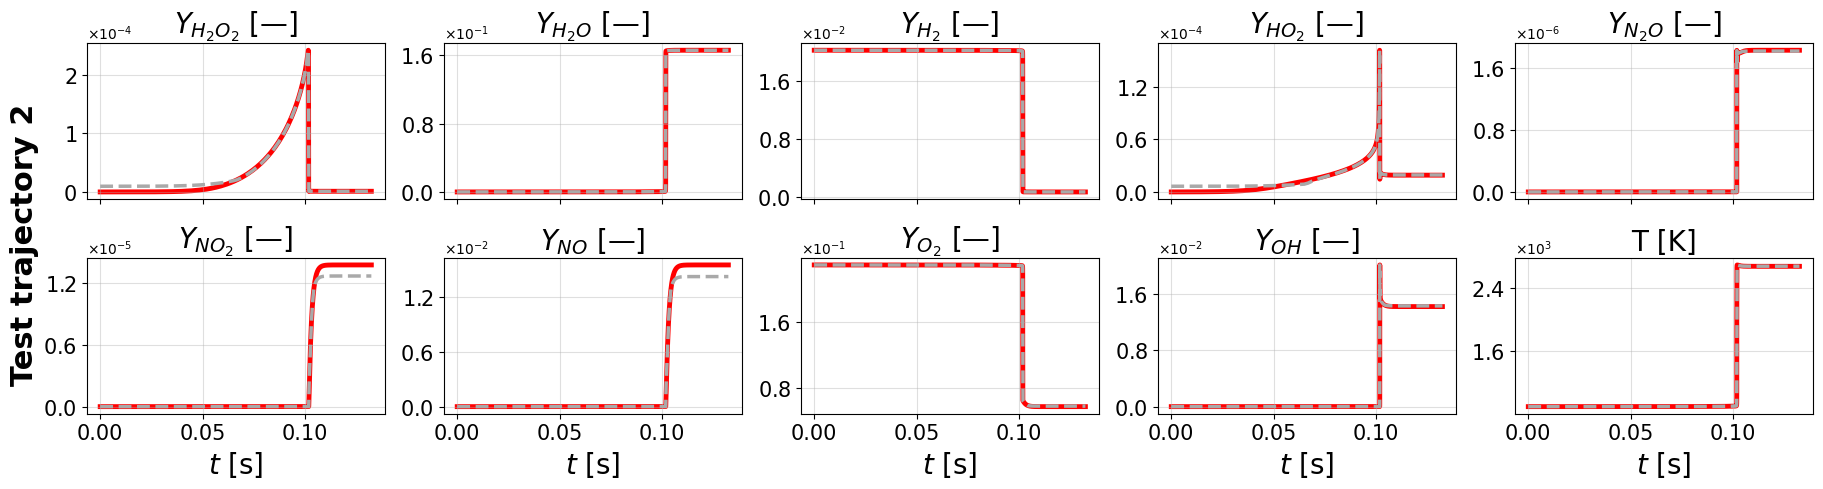

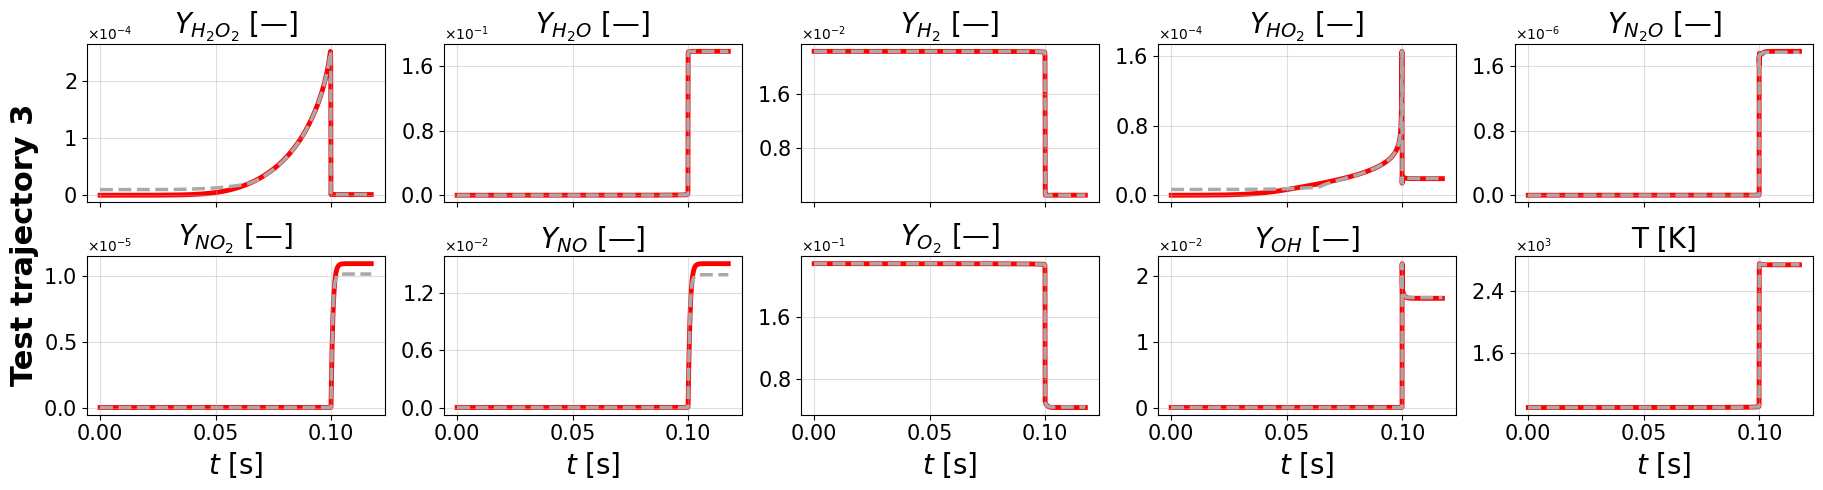

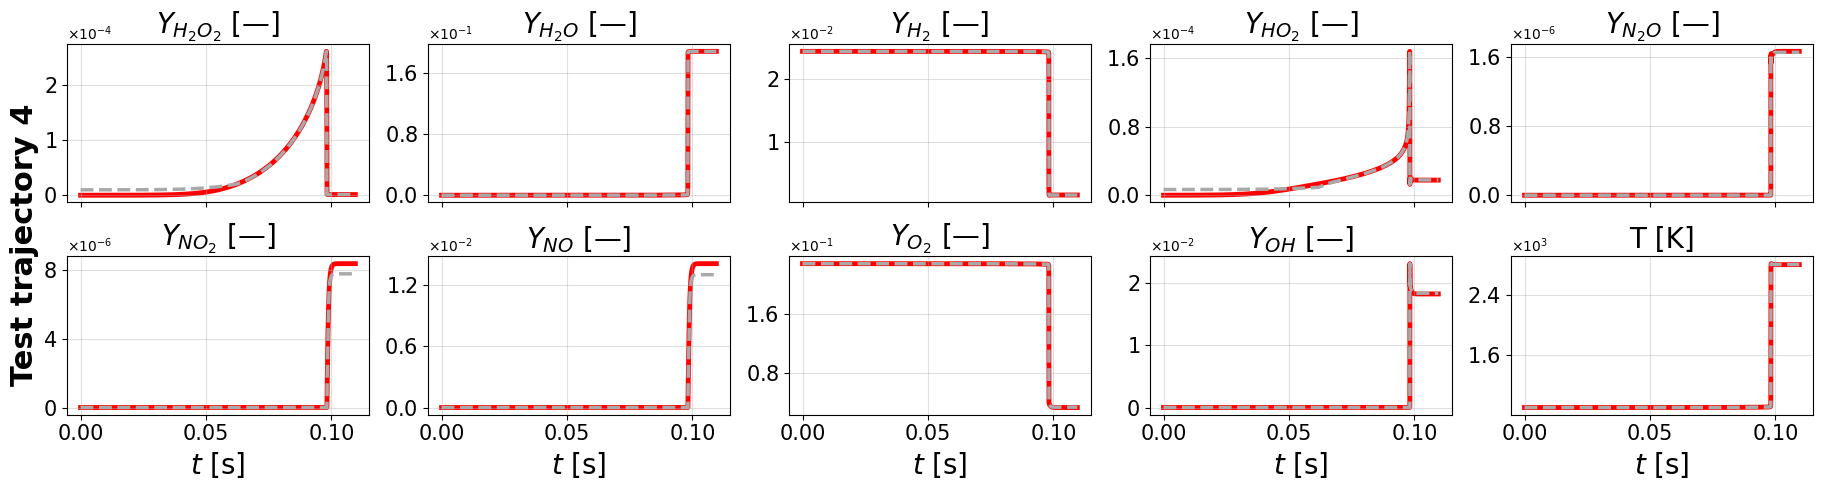

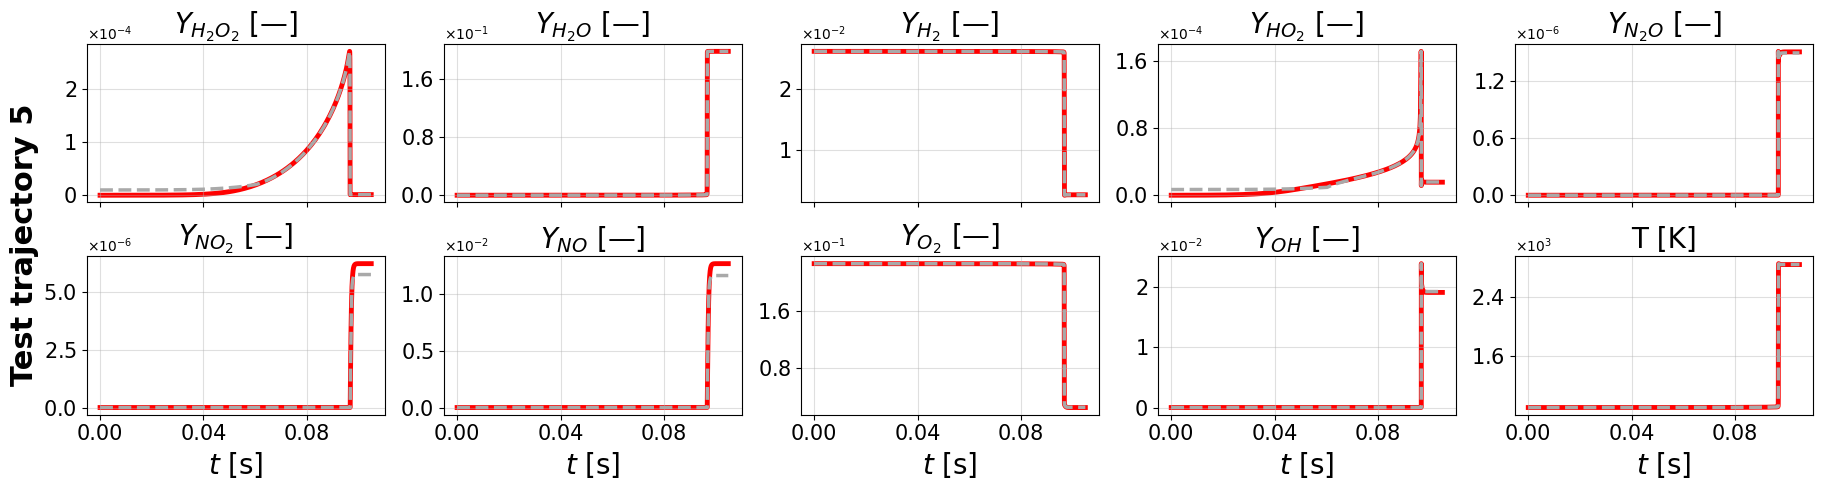

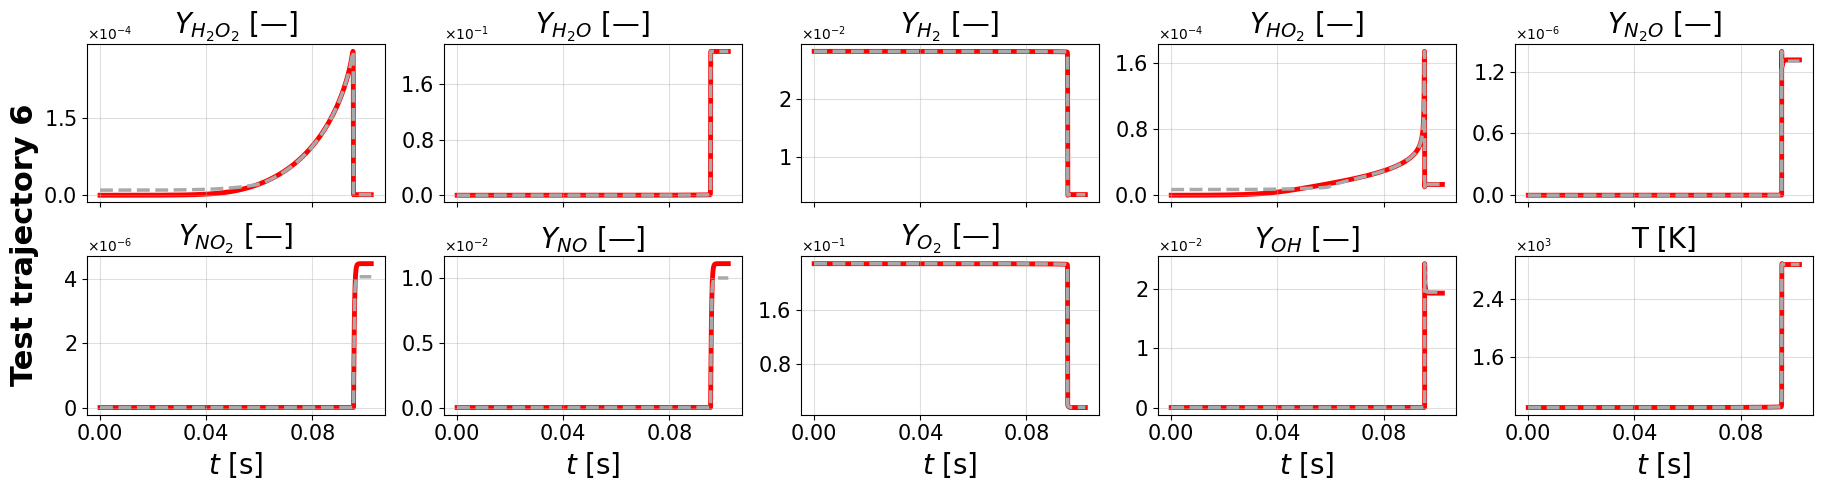

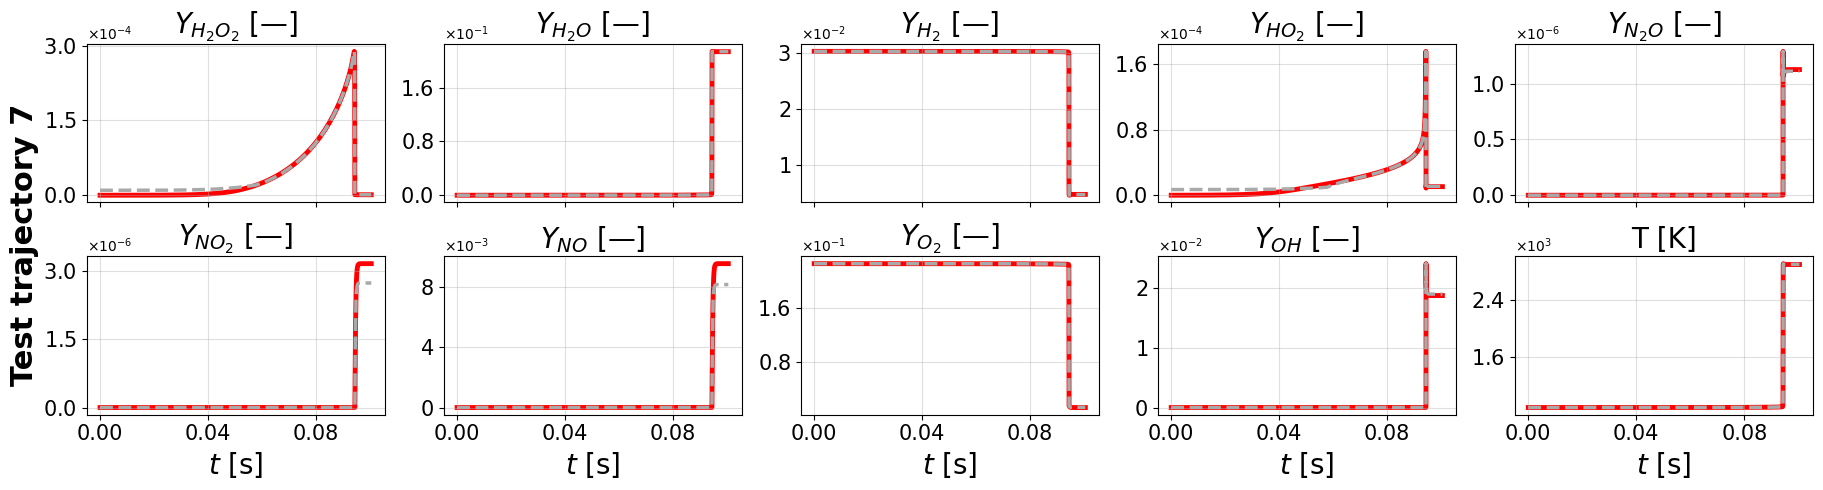

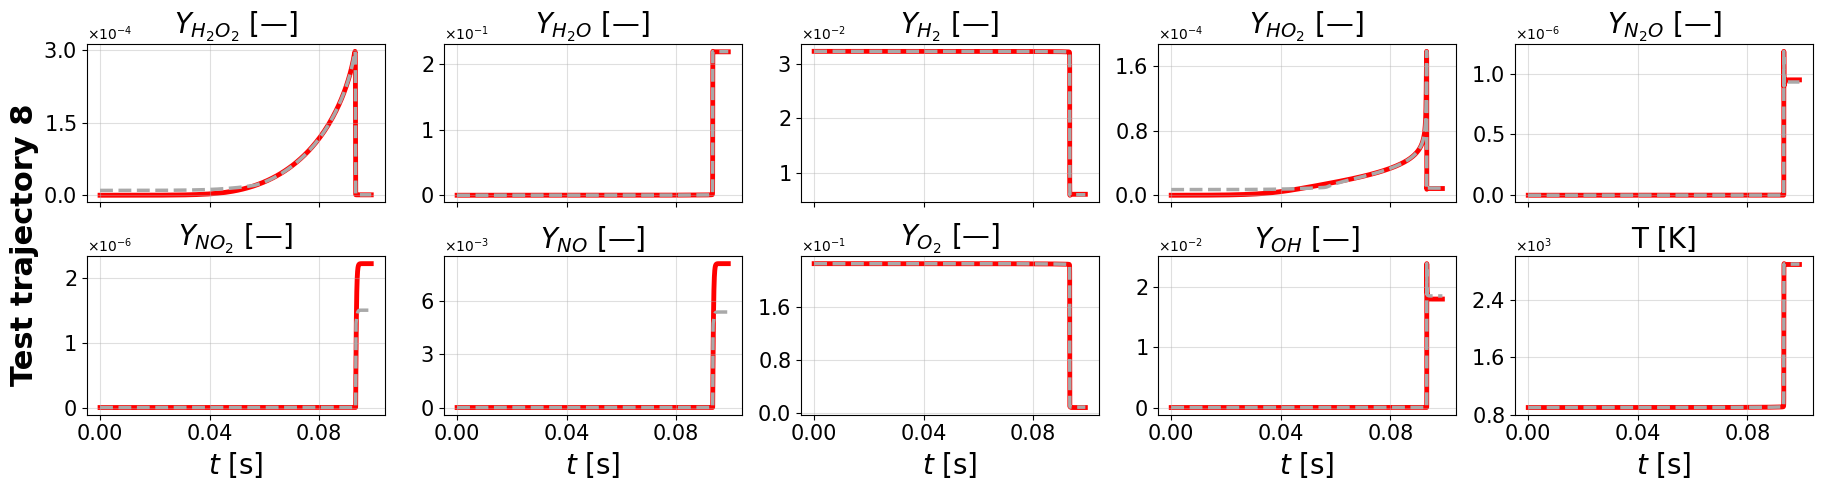

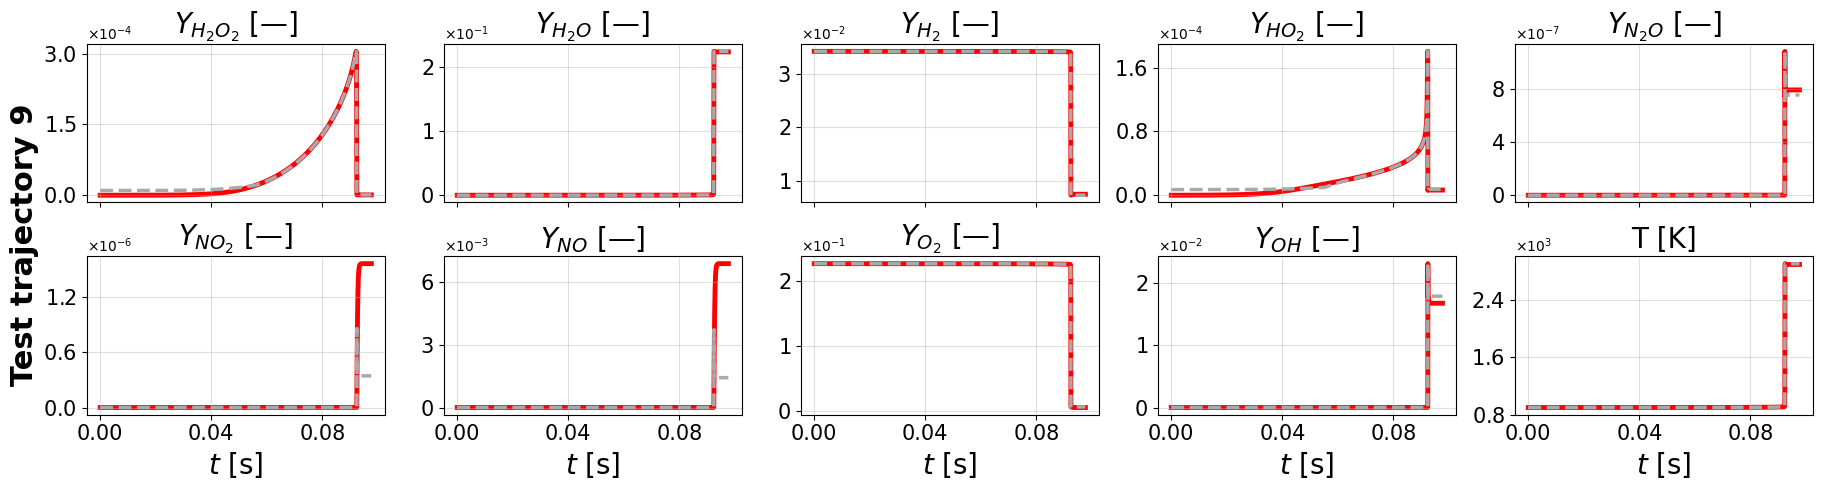

In [60]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/Given true heuristic PV/"
name = "Heuristic with true PV - extra experiment - A posteriori - Tabulation"

Output_species_Latex = [species.replace('2', '_2') for species in QoIs]

idx_start_simulation = 0

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    
    for idxQoI in range(len(QoIs)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time[idx_start_simulation:], test_trajectory[QoIs[idxQoI]].iloc[idx_start_simulation:], label = "FOM", c="red", linestyle="-", linewidth=3.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time[idx_start_simulation:], reconstruction_Xu_fromTruePV[idxSimulation][:, idxQoI], label = 'Recontsturction given true heuristic PV', c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      #ax.plot(test_trajectory_time[idx_start_simulation:],reconstruction_optimized[idxSimulation][:, idxQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(QoIs[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      #ax.set_xlim([0.09, 0.11])

      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(QoIs), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='Recontsturction given true heuristic PV'),
        #Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with an optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")

    if(i==0):
        plt.show()

#### Zoom in

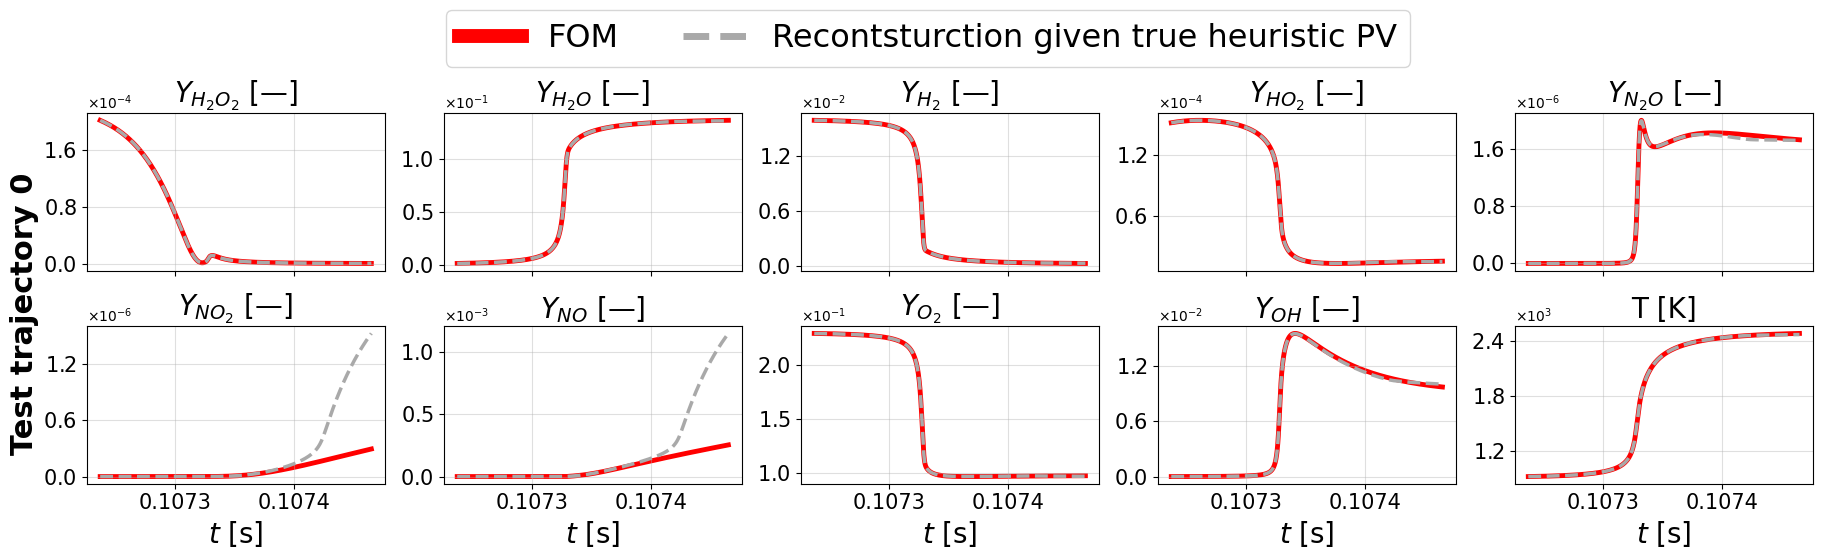

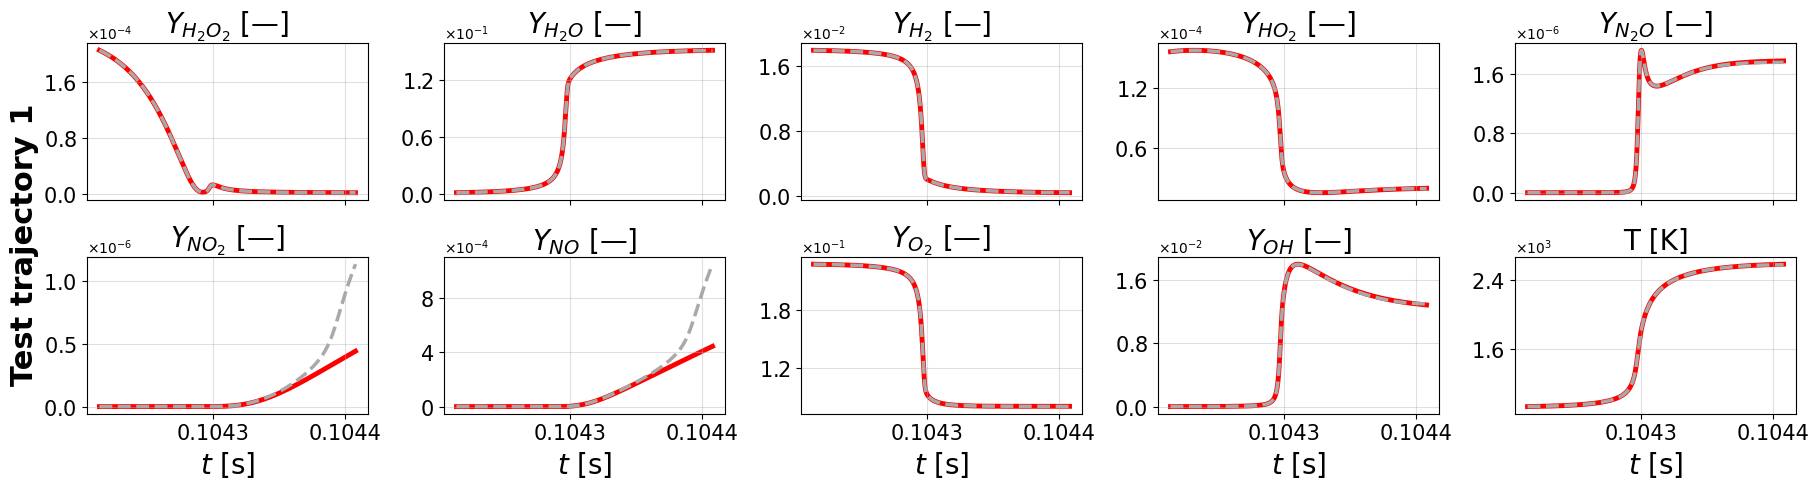

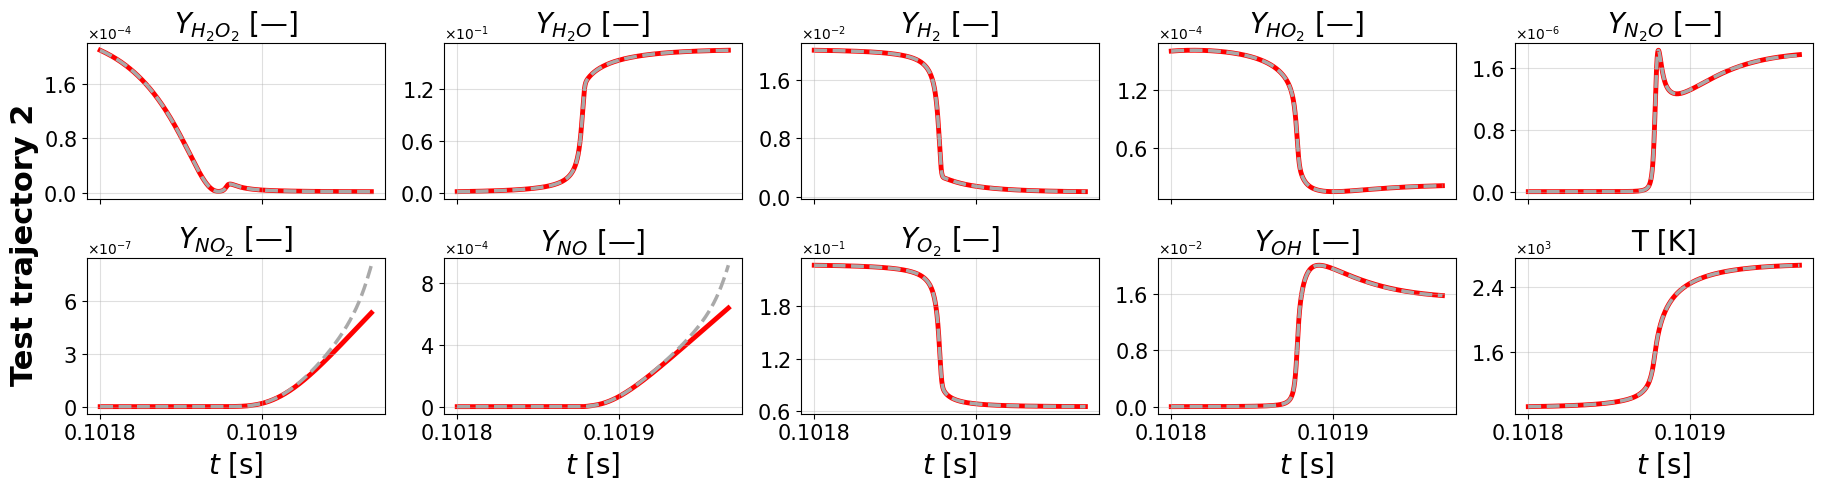

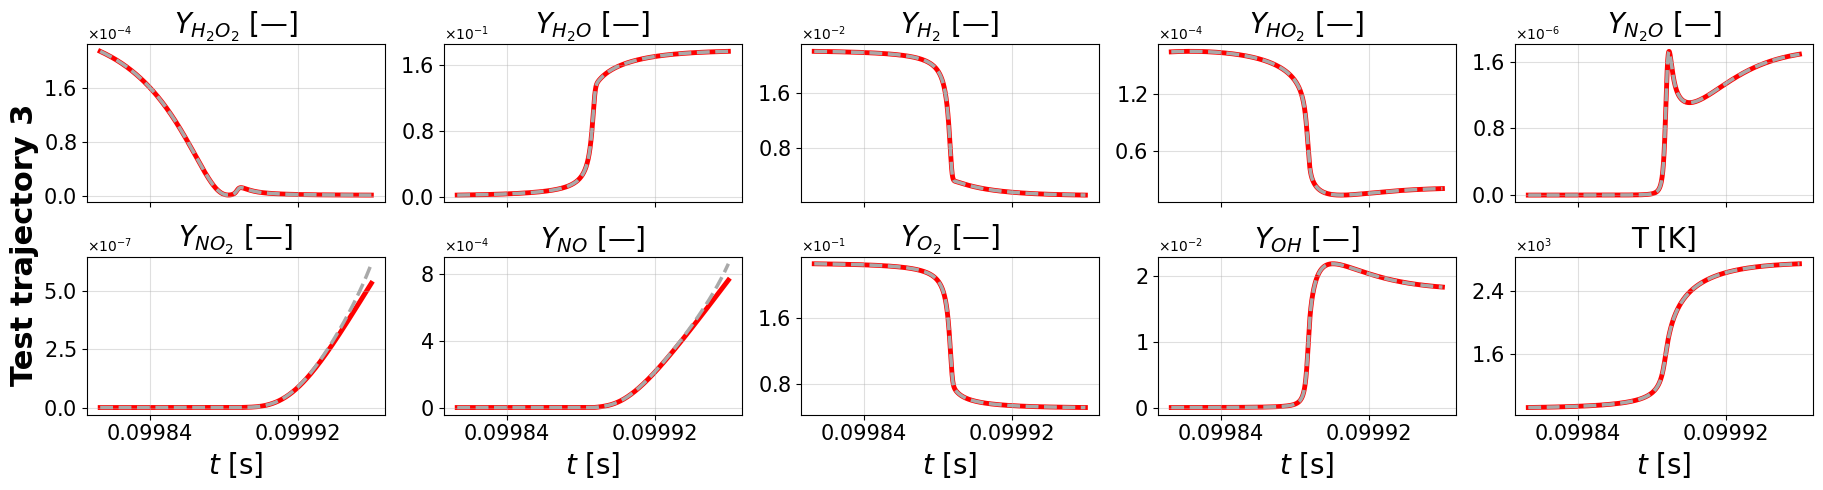

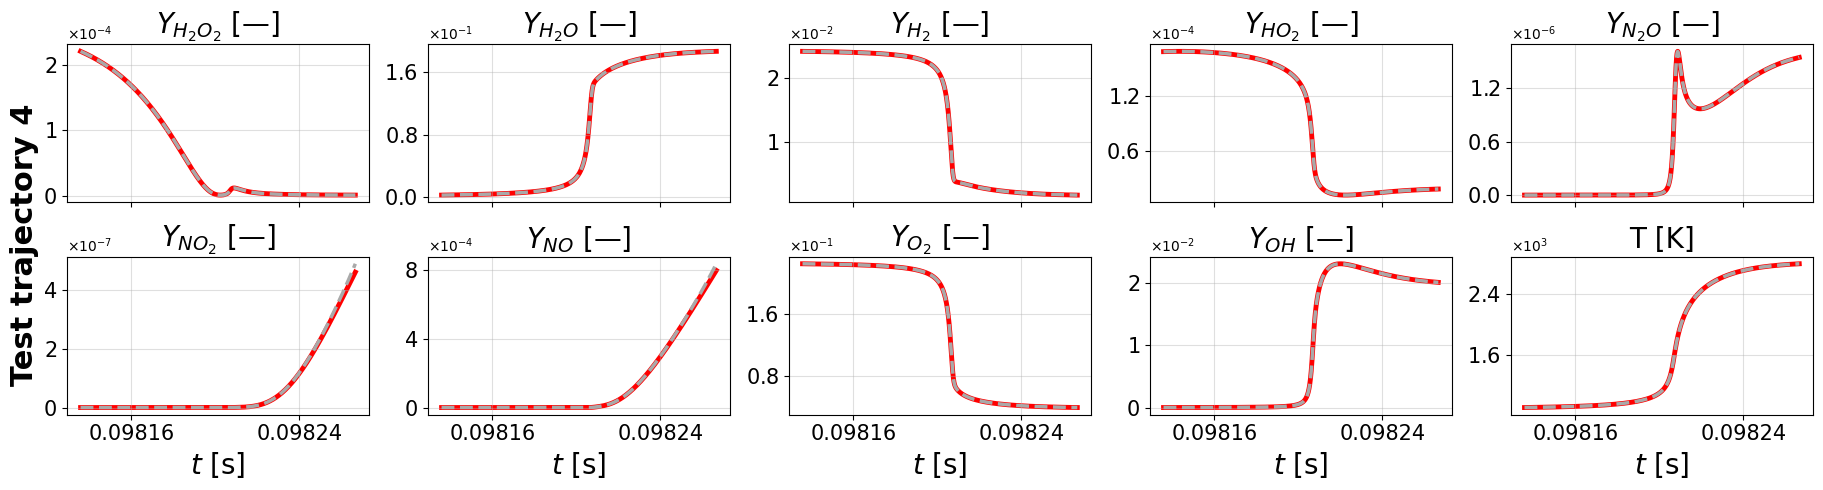

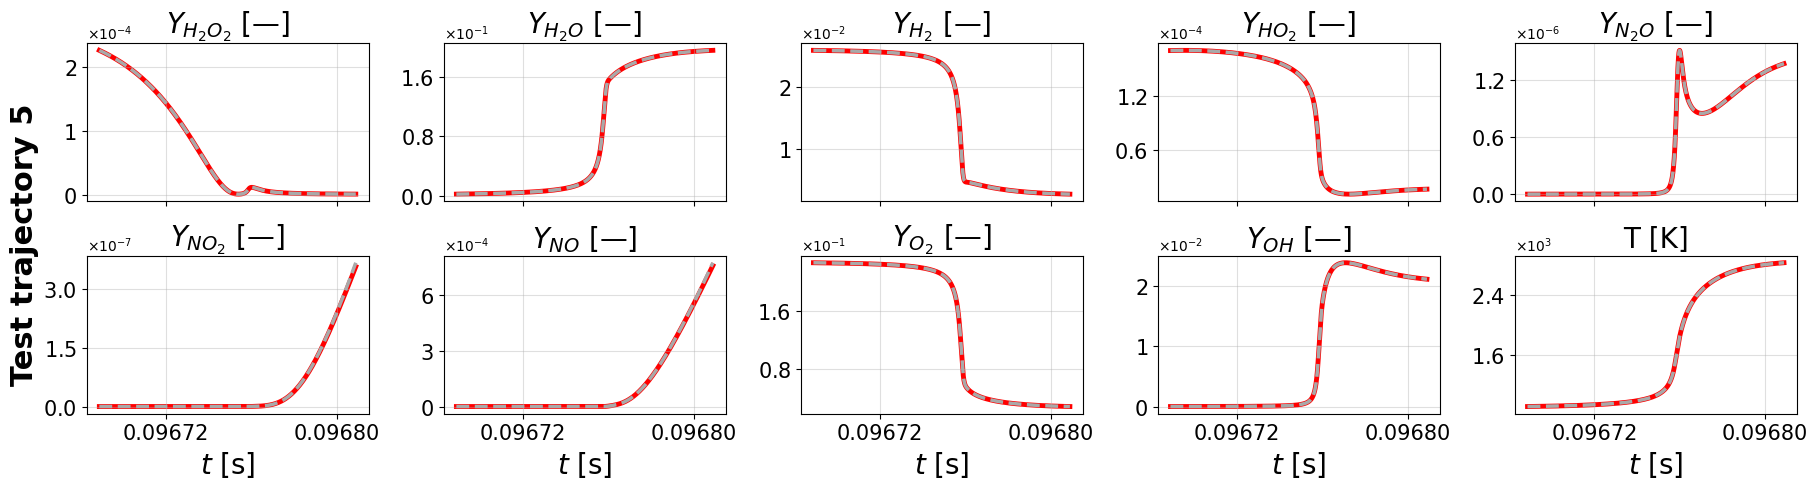

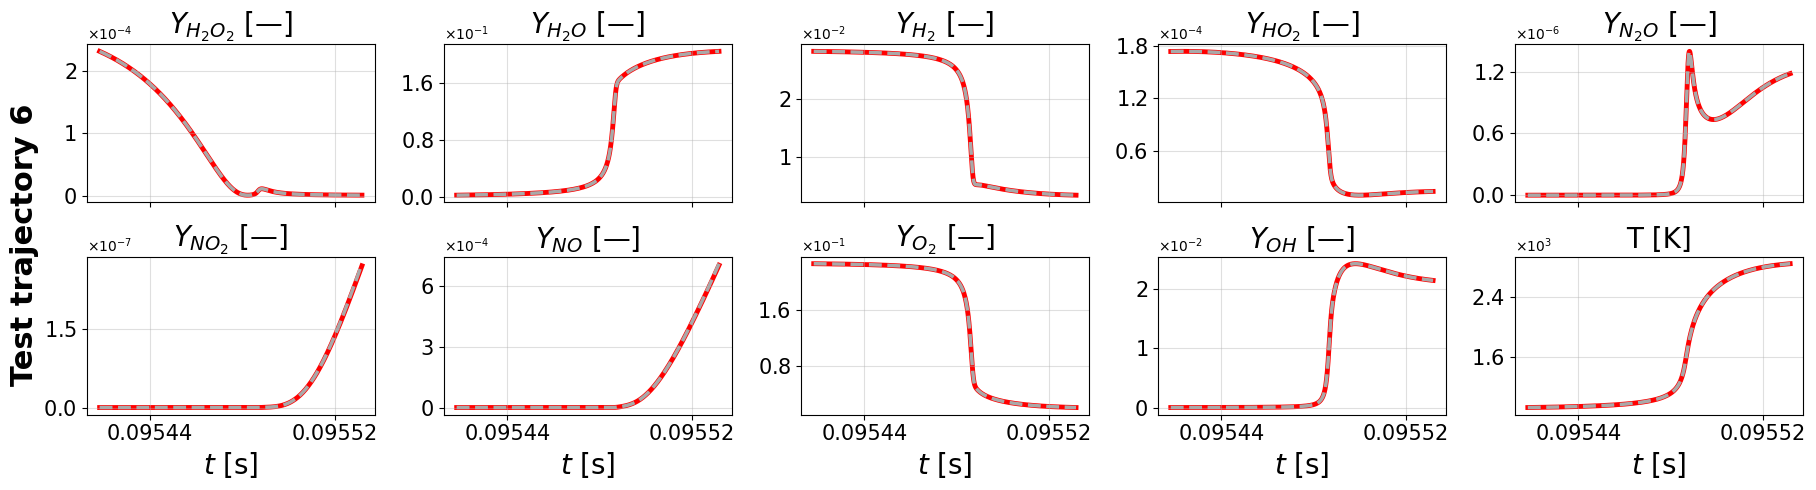

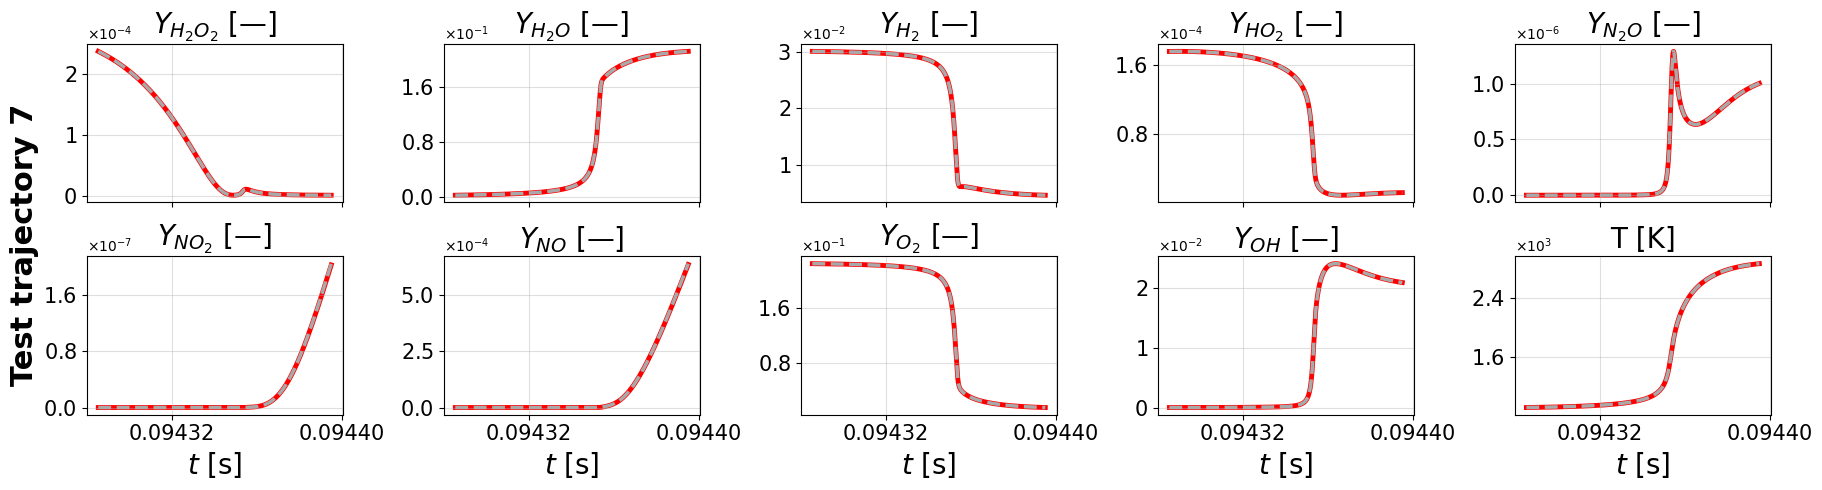

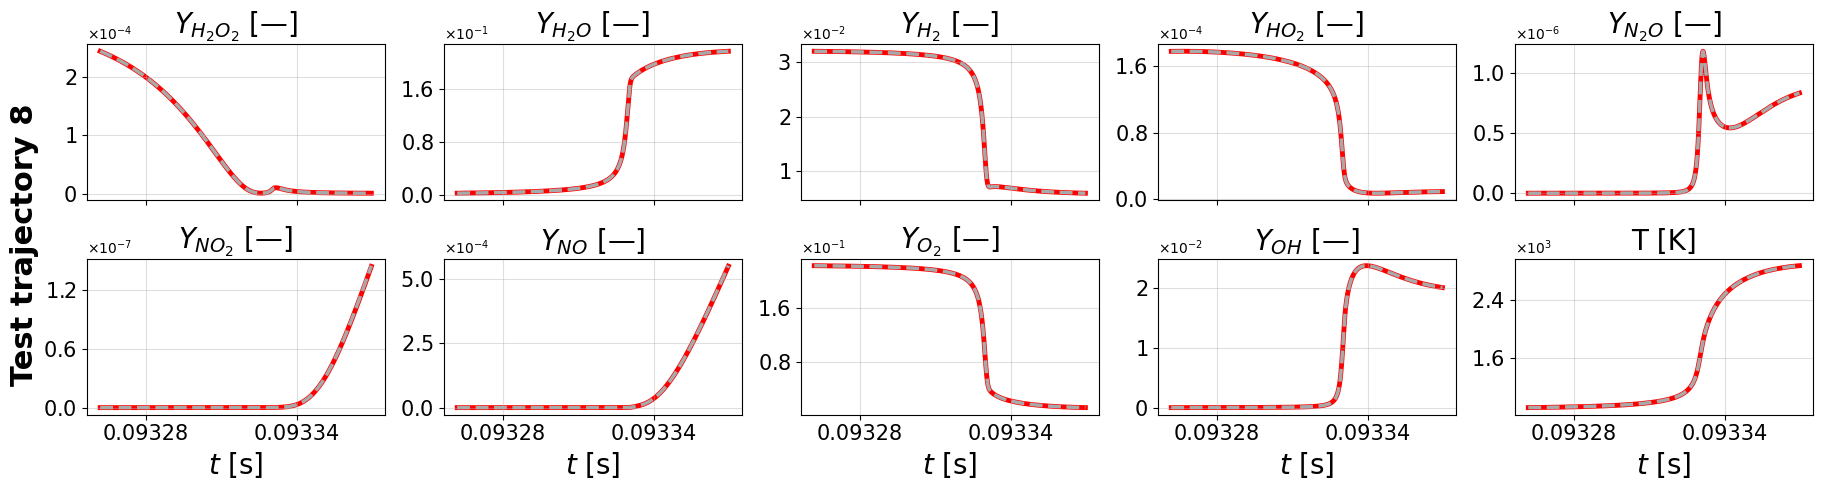

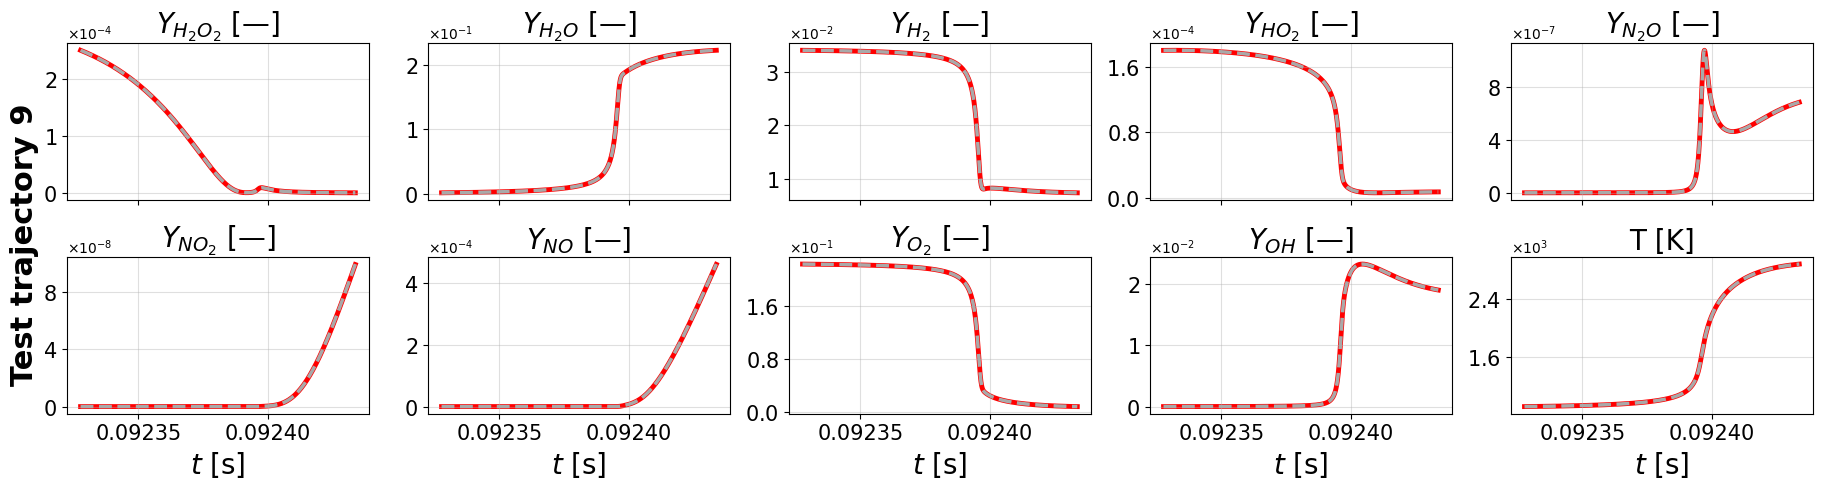

In [61]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/Given true heuristic PV/Zoom in/"
name = "Heuristic with true PV - extra experiment - zoom - A posteriori - Tabulation"

Output_species_Latex = [species.replace('2', '_2') for species in QoIs]

idx_start_simulation = 0

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    

    ##############################################
    # Get the first and last index of the ignition
    ##############################################

    H2O_array = test_trajectory["H2O"].to_numpy()
    
    max_val = H2O_array.max()
    lower_threshold = 0.01 * max_val
    upper_threshold = 0.99 * max_val

    idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
    idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

    #print(f"H2O is monotonically increasing: {np.all(np.diff(H2O_array) >= 0)}")
    # holds more or less, true for the first five arrays

    #######################################
    # Plot the different QoIs of the figure
    #######################################
    
    for idxQoI in range(len(QoIs)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time[idx_1:idx_99], test_trajectory[QoIs[idxQoI]].iloc[idx_1:idx_99], label = "FOM", c="red", linestyle="-", linewidth=3.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time[idx_1:idx_99], reconstruction_Xu_fromTruePV[idxSimulation][idx_1:idx_99, idxQoI], label = 'Recontsturction given true heuristic PV', c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      #ax.plot(test_trajectory_time[idx_start_simulation:],reconstruction_optimized[idxSimulation][:, idxQoI], label = "ROM with an optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(QoIs[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      #ax.set_xlim([0.09, 0.11])

      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(QoIs), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='Recontsturction given true heuristic PV'),
        #Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with an optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")

    if(i==0):
        plt.show()